In [1]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import stuff
import sys,os,os.path

#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/gluster/data/next/software/IC_satkill/")
#sys.path.append("/gluster/data/next/software/IC_sophronia/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/gluster/data/next/software/IC_satkill/'

from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers

import functions as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from functions import plot_fit as plot_fit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

### Functions for fitting

In [18]:
def histogram_fit(fnc, sig_data, binning, p0, fit_labels, bounds = []):
    '''
    fit a function from histogram data, return the fitting parameters
    '''


    # Use positron data to collect the C1 and C2 values from the signal fit
    s_cnts, s_edges, s_patches = func.plot_hist(sig_data, binning = binning, log = False, data = True)

    
    s_centres = shift_to_bin_centers(s_edges)

    # FIT
    if (bounds == []):
        return curve_fit(fnc, s_centres, s_cnts, p0, maxfev = 500000)
    else:
        return curve_fit(fnc, s_centres, s_cnts, p0, maxfev = 500000, bounds = bounds)

def fom_calc_MC(cut_data, positron_data, cut_list, binning = 80, verbose = False, MC_data = True):
    '''
        calculate FOM via fitting using MC information for C1 and C2
        start the cut list at non-zero. eg cut_list = [0.1, 0.2, ...]
        If MC data is true, multiply positron event_ids by 2
    '''
    # preset some parameters for sanity purposes
    emin = 1.5
    emax = 1.7

    
    if (MC_data == True):
        pos_ids = (positron_data['event_id'].unique())*2
    else:
        pos_ids = (positron_data['event_id'].unique())

    # select only events in which events have positrons
    sig_data = cut_data[cut_data['event'].isin(pos_ids)]
    bck_data = cut_data[~cut_data['event'].isin(pos_ids)]


    print("Obtaining C1 and C2")
    #####            C1 AND C2 ACQUISITION          #####
    # p0 is apriori
    p0 = ([1, 1, 1.58, 0.3, 0.8, 0])
    fit_labels = ['B1', 'A', 'mu', 'sigma', 'C1', 'C2']
    
    # fit the histogram
    s_popt, s_pcov = histogram_fit(func.sig_func, sig_data, binning, p0, fit_labels)

    
    if (verbose == True):
        print("=========================== SIGNAL FIT ============================")
        func.plot_fit(func.sig_func, np.linspace(emin, emax, 1000), s_popt, fit_labels)
        func.plot_hist(sig_data, binning = 80, title='Signal fit', log = False)
        plt.show()
        func.print_parameters(s_popt, s_pcov, fit_labels)
    
    # Set C1 and C2
    C1 = s_popt[4]
    C2 = s_popt[5]

    # C1 and C2 control
    if (C1 < 0):
        C1 = 0
    if (C2 < 0):
        C2 = 0

    print("C1: {}, C2: {}".format(C1, C2))



    #####           MU AND SIGMA ACQUISITION            #####

    # apriori
    g_p0 = [500, 1.6, 0.01]
    g_labels = ['A', 'mu', 'sigma']

    # collect histogram information

    #cnt, edges, patches = func.plot_hist(cut_data, binning = binning, log = False, data = True)
    # fit
    #g_popt, g_pcov = curve_fit(func.gauss, centres, cnts, g_p0, maxfev = 500000)
    g_popt, g_pcov = histogram_fit(func.gauss, cut_data, binning, g_p0, g_labels)
    # set mu and sigma
    mu      = g_popt[1]
    sigma   = g_popt[2]

    print("mu: {}, sigma: {}".format(mu, sigma))

    if (verbose == True):
        print("=========================== GAUSSIAN FIT ============================")
        func.plot_fit(func.gauss, np.linspace(emin, emax, 1000), g_popt, g_labels)
        func.plot_hist(cut_data, binning = 80, title='Gauss fit', log = False)
        plt.show()
        func.print_parameters(g_popt, g_pcov, g_labels)


    #####          NS AND NB ACQUISITION                #####

    fixed_sig_bck_func = lambda x, ns, a, nb, tau: func.sig_bck_func(x, ns, a, mu, sigma, C1, C2, nb, tau)

    # apriori
    sb_p0 = [400, 1, 20, 0.1]
    sb_labels = ['ns', 'a', 'nb', 'tau']

    # fit
    sb_popt, sb_pcov = histogram_fit(fixed_sig_bck_func, cut_data, binning, sb_p0, sb_labels)
    #sb_popt, sb_pcov = curve_fit(fixed_sig_bck_func, centres, cnts, sb_p0, maxfev = 500000)
    # take bin widths to calculate number of events
    _, edges, _ =func.plot_hist(cut_data, binning = binning, log = False, data = True)
    bin_width = edges[1] - edges[0]
    ns0 = quad(func.sig_func, emin, emax, args = (sb_popt[0],sb_popt[1], mu, sigma, C1, C2))/bin_width
    nb0 = quad(func.bck_func, emin, emax, args = (sb_popt[2], sb_popt[3]))/bin_width

    if (verbose == True):

        print("=========================== FULL FIT ============================")
        func.plot_fit(fixed_sig_bck_func, np.linspace(emin, emax, 1000), sb_popt, sb_labels)
        func.plot_hist(cut_data, binning = 80, title='Full fit', log = False)
        plt.show()
        func.print_parameters(sb_popt, sb_pcov, sb_labels)

        print('ns0      = {}'.format(ns0[0]))
        print('nb0      = {}'.format(nb0[0]))
        print("total    = {:.0f}".format(ns0[0]+nb0[0]))
        print("Event no = {}".format(len(cut_data.index)))
    
    
    # create list for fom values
    e       = []
    b       = []
    ns_l      = []
    nb_l      = []
    fom     = []
    fom_err = []
    e_err = []
    b_err = []

    ns_l.append(ns0[0])
    nb_l.append(nb0[0])

    # wipe variables to stop variable bleed over
    del g_popt, g_pcov, mu, sigma, sb_popt, sb_pcov, bin_width

    if (verbose == True):
        print("=========================== ====================== ===========================")
        print("=========================== BLOB 2 CUT STARTS HERE ===========================")
        print("=========================== ====================== ===========================")

    for i in range(len(cut_list)):

        print("Applying cut {} MeV".format(cut_list[i]))

        blob_data = cut_data[(cut_data['eblob2'] > cut_list[i])]

        # collect gaussian peak
        g_popt, g_pcov = histogram_fit(func.gauss, blob_data, binning, g_p0, g_labels)
        # set mu and sigma
        mu      = g_popt[1]
        sigma   = g_popt[2]

        if (verbose == True):
            print("=========================== GAUSSIAN FIT ============================")
            func.plot_fit(func.gauss, np.linspace(emin, emax, 1000), g_popt, g_labels)
            func.plot_hist(blob_data, binning = 80, title='Gauss fit', log = False)
            plt.show()
            func.print_parameters(g_popt, g_pcov, g_labels)


        # collect nb and ns
        sb_popt, sb_pcov = histogram_fit(fixed_sig_bck_func, blob_data, binning, sb_p0, sb_labels, bounds = ([0, -np.inf, 0, -np.inf],[np.inf, np.inf, np.inf, np.inf]))
        # take bin widths to calculate number of events
        _, edges, _ =func.plot_hist(blob_data, binning = binning, log = False, data = True, output = False)
        bin_width = edges[1] - edges[0]
        ns = quad(func.sig_func, emin, emax, args = (sb_popt[0],sb_popt[1], mu, sigma, C1, C2))/bin_width
        nb = quad(func.bck_func, emin, emax, args = (sb_popt[2], sb_popt[3]))/bin_width
        ns_l.append(ns[0])
        nb_l.append(nb[0])
        if (verbose == True):

            print("=========================== FULL FIT ============================")
            plt.clf()
            func.plot_fit(fixed_sig_bck_func, np.linspace(emin, emax, 1000), sb_popt, sb_labels, lgnd='Full fit')
            func.plot_fit(func.bck_func, np.linspace(emin, emax, 1000), sb_popt[-2:], sb_labels[-2:], lgnd='Background fit', colour = 'yellow')#, linestyle = 'dashed')

            # collect all sb_vales
            s_popt = [sb_popt[0], sb_popt[1], mu, sigma, C1, C2]
            s_labels = ['ns', 'a', 'mu', 'sigma', 'C1', 'C2']
            func.plot_fit(func.sig_func, np.linspace(emin, emax, 1000), s_popt, s_labels, lgnd='Signal fit', colour= 'green')#, linestyle = 'dashed')
            
            
            func.plot_hist(blob_data, binning = 80, title='Full fit', log = False, label = 'Data')
            plt.legend()
            plt.show()
            func.print_parameters(sb_popt, sb_pcov, sb_labels)

            print('ns - {}'.format(ns[0]))
            print('nb - {}'.format(nb[0]))
            print("total = {:.0f}".format(ns[0]+nb[0]))
            print("Event no = {}".format(len(blob_data.index)))
        
        e_check = ns[0]/ns0[0]
        b_check = nb[0]/nb0[0]
        fom_check = e_check/np.sqrt(b_check)

        e.append(e_check)
        b.append(b_check)
        fom.append(fom_check)

        # errors for fom
        e_err.append(func.ratio_error(e[i],ns[0],ns0[0],np.sqrt(ns[0]),np.sqrt(ns0[0])))
        b_err.append(func.ratio_error(b[i],nb[0],nb0[0],np.sqrt(nb[0]),np.sqrt(nb0[0])))
        fom_err.append(func.fom_error(e[i], b[i], e_err[i], b_err[i]))

        if (verbose == True):
            print('fom - {:.2f} ± {:.2f}'.format(fom_check, fom_err[i]))
            print('e - {:.2f} ± {:.2f}'.format(e_check, e_err[i]))
            print('b - {:.2f} ± {:.2f}'.format(b_check, b_err[i]))

        # wipe variables here
        del blob_data, g_popt, g_pcov, mu, sigma, sb_popt, sb_pcov, ns, nb, bin_width, e_check, b_check, fom_check
    
    return (fom, fom_err, ns_l, nb_l)



### Load data

In [4]:
 

pre_dir = '/gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/BEERSHEBA_STUDY/blobR_voxelS/12_12_18/'
#pre_dir = '/gluster/data/next/files/TOPOLOGY_John/HPR_PARAMETER_CHECK/data/'
#folder_paths = [pre_dir + 'PORT_1a/isaura/', pre_dir + '/PORT_1b/isaura/', pre_dir + '/PORT_2a/isaura/', pre_dir + '/PORT_2b/isaura/']
folder_paths = [pre_dir + 'PORT_1a/isaura/']
full_tracks = func.collate_ports(folder_paths)

Porting /gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/BEERSHEBA_STUDY/blobR_voxelS/12_12_18/PORT_1a/isaura/
50
100
150
200
250
300
Done! Tracks available: 87009


### Apply cuts

In [6]:
# satellite removal
low_e_cut_tracks = full_tracks[full_tracks.energy > 0.05]
event_counts = low_e_cut_tracks['event'].value_counts(sort = False)
low_e_cut_tracks['numb_of_tracks'] = low_e_cut_tracks['event'].map(event_counts)

cut_tracks = func.apply_cuts(low_e_tracks, lower_z = 20, upper_z = 1170, r_lim = 415)

/tmp/ipykernel_1907099/1331950522.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_e_cut_tracks['numb_of_tracks'] = low_e_cut_tracks['event'].map(event_counts)


Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 46.25 %
Absolute Cut efficiency:
Efficiency: 46.25 %
One track cut
Relative Cut efficiency:
Efficiency: 66.41 %
Absolute Cut efficiency:
Efficiency: 60.06 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 78.67 %
Absolute Cut efficiency:
Efficiency: 70.97 %
Energy cut
Relative Cut efficiency:
Efficiency: 9.66 %
Absolute Cut efficiency:
Efficiency: 6.18 %


### Collect positrons

In [11]:
# find positron events per port
#pos_events = func.positron_ports(folder_paths)

# currently as we're doing just one port, can use this file generated
posi_dir = '/gluster/data/next/notebooks/john_books/soph_df_data/'
pos_events = pd.read_hdf(posi_dir + 'Tl_signal_true_info.h5')
display(pos_events.head())

,event_id,particle_id,hit_id,x,y,z,time,energy,label
3236,8,52,0,315.166870,208.526917,731.868896,1.128019,0.000005,ACTIVE
3237,8,51,0,315.680695,208.035660,732.565308,0.961651,0.001719,ACTIVE
3238,8,51,1,316.120941,207.520065,733.248108,0.965438,0.001694,ACTIVE
3239,8,51,2,316.652252,206.863007,733.708008,0.969227,0.000674,ACTIVE
3240,8,51,3,316.177185,206.028381,733.763306,0.973017,0.004037,ACTIVE


### Apply FOM

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
Obtaining C1 and C2
=========================== SIGNAL FIT ============================


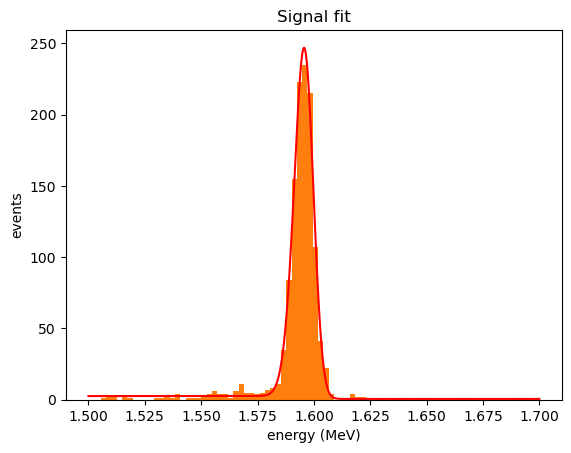

        Fitting output      
B1: 2.6257 ± 0.0259
A: -1.2375 ± 0.1389
mu: 1.5986 ± 0.0002
sigma: 0.0055 ± 0.0002
C1: 0.3815 ± 0.1502
C2: 0.2121 ± 0.2044
C1: 0.3814957480205809, C2: 0.2121390391423544
mu: 1.5952888509129193, sigma: 0.004615625387426586
=========================== GAUSSIAN FIT ============================


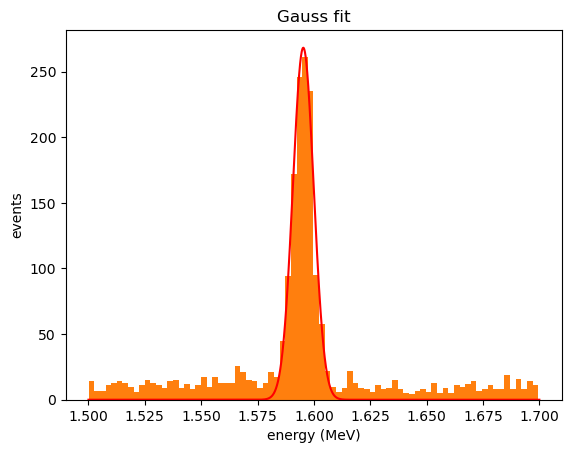

        Fitting output      
A: 268.1152 ± 8.3003
mu: 1.5953 ± 0.0002
sigma: 0.0046 ± 0.0002
=========================== FULL FIT ============================


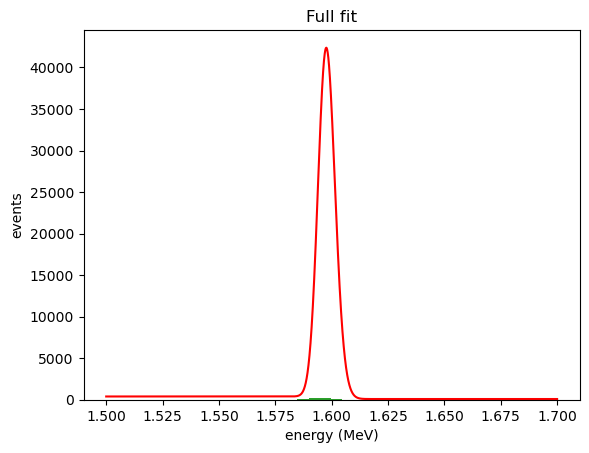

        Fitting output      
ns: 400.0000 ± 52.0242
a: 1.0000 ± 0.4621
nb: 20.0000 ± 12891840774.1488
tau: 0.1000 ± 4624247.3958
ns0      = 178988.69815814524
nb0      = 0.0002122754117618294
total    = 178989
Event no = 2031
=========================== ====================== ===========================
=========================== BLOB 2 CUT STARTS HERE ===========================
=========================== ====================== ===========================
Applying cut 0.0 MeV
=========================== GAUSSIAN FIT ============================


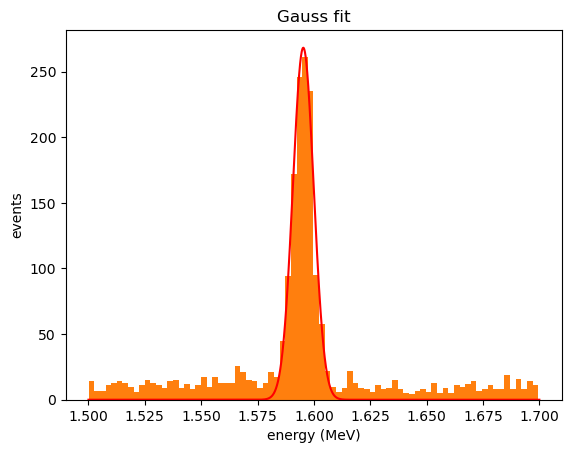

        Fitting output      
A: 268.1152 ± 8.3003
mu: 1.5953 ± 0.0002
sigma: 0.0046 ± 0.0002
=========================== FULL FIT ============================


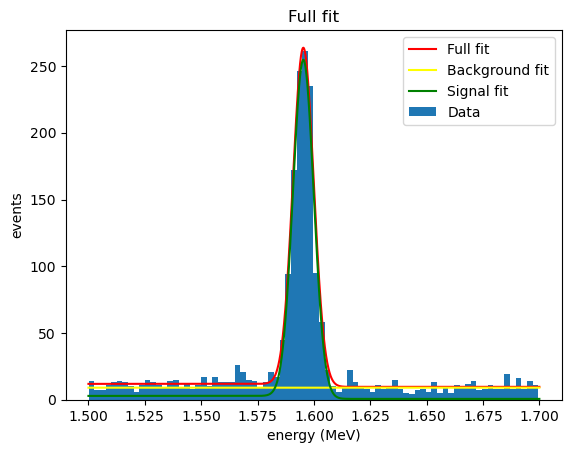

        Fitting output      
ns: 2.9266 ± 0.0423
a: 0.0088 ± 0.0244
nb: 9.0213 ± 19.6953
tau: 185212.2968 ± 46736024993.8816
ns - 1309.553179852934
nb - 723.994589610453
total = 2034
Event no = 2031
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 3410638.02 ± 234091608.85
Applying cut 0.01 MeV
=========================== GAUSSIAN FIT ============================


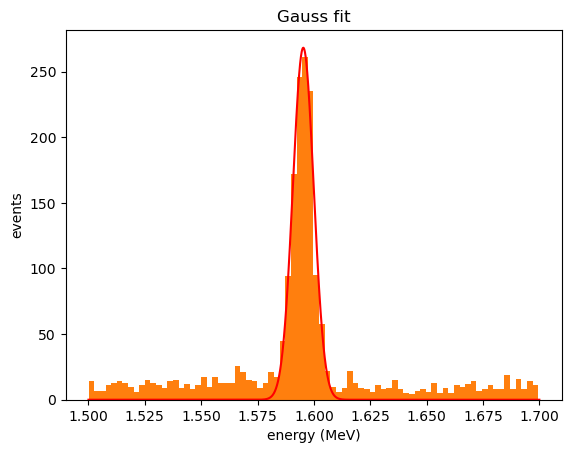

        Fitting output      
A: 268.1152 ± 8.3003
mu: 1.5953 ± 0.0002
sigma: 0.0046 ± 0.0002
=========================== FULL FIT ============================


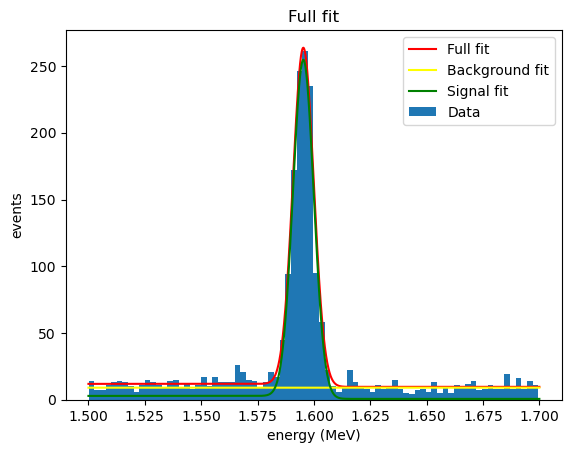

        Fitting output      
ns: 2.9266 ± 0.0423
a: 0.0088 ± 0.0244
nb: 9.0213 ± 19.6953
tau: 185212.2968 ± 46736024993.8816
ns - 1309.553179852934
nb - 723.994589610453
total = 2034
Event no = 2031
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 3410638.02 ± 234091608.85
Applying cut 0.02 MeV
=========================== GAUSSIAN FIT ============================


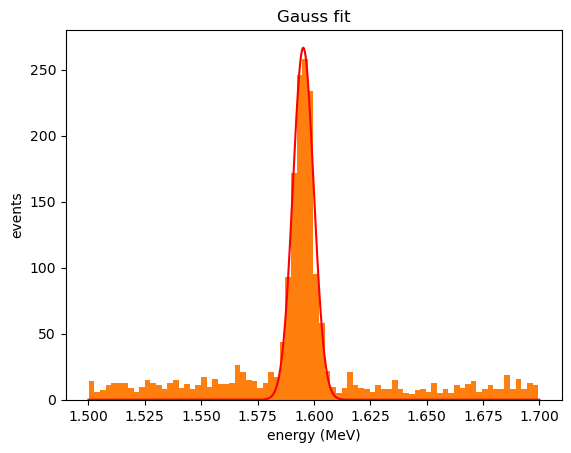

        Fitting output      
A: 266.7125 ± 8.1368
mu: 1.5953 ± 0.0002
sigma: 0.0046 ± 0.0002
=========================== FULL FIT ============================


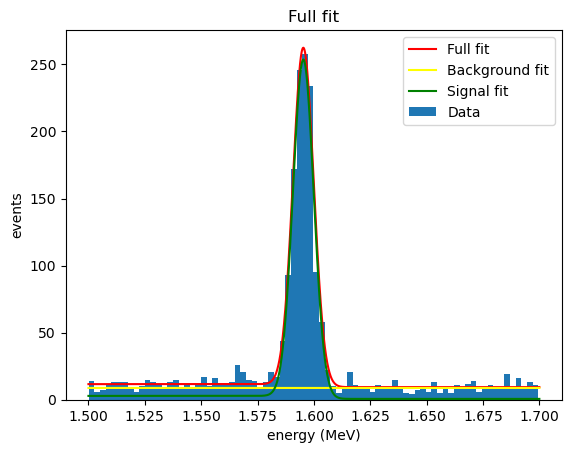

        Fitting output      
ns: 2.9169 ± 0.0418
a: 0.0088 ± 0.0243
nb: 8.7752 ± 19.3691
tau: 112128.6403 ± 17323224082.5338
ns - 1305.2478887852712
nb - 704.2401749694969
total = 2009
Event no = 2007
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 3317577.71 ± 227704348.38
Applying cut 0.03 MeV
=========================== GAUSSIAN FIT ============================


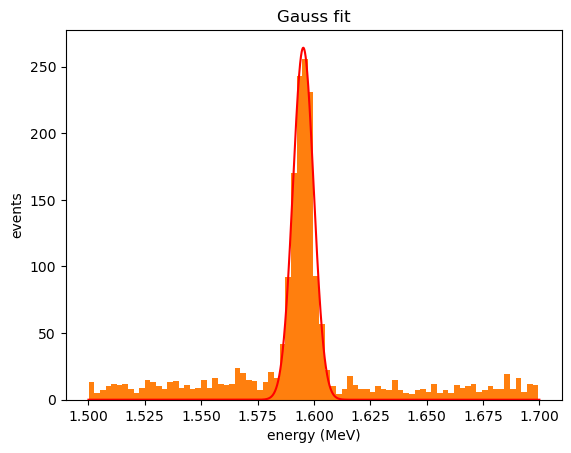

        Fitting output      
A: 264.2124 ± 7.7459
mu: 1.5953 ± 0.0002
sigma: 0.0046 ± 0.0002
=========================== FULL FIT ============================


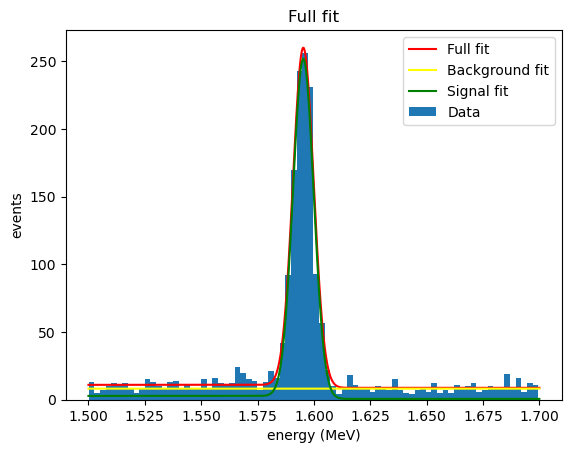

        Fitting output      
ns: 2.8846 ± 0.0404
a: 0.0088 ± 0.0238
nb: 8.1813 ± 18.7417
tau: 186547.1873 ± 49783860403.4534
ns - 1290.7552814035998
nb - 656.5788789479478
total = 1947
Event no = 1945
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 3093051.96 ± 212293863.28
Applying cut 0.04 MeV
=========================== GAUSSIAN FIT ============================


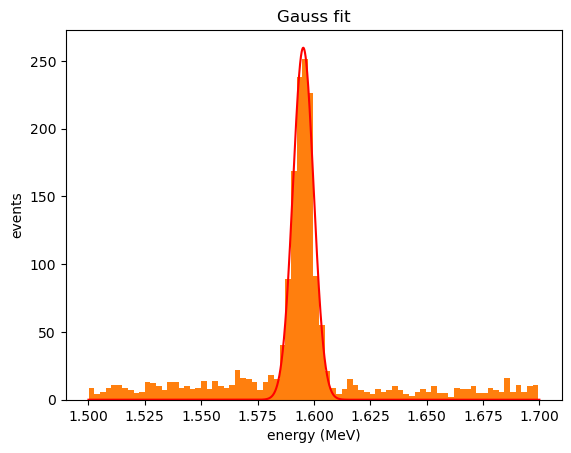

        Fitting output      
A: 259.6458 ± 6.8898
mu: 1.5953 ± 0.0001
sigma: 0.0046 ± 0.0001
=========================== FULL FIT ============================


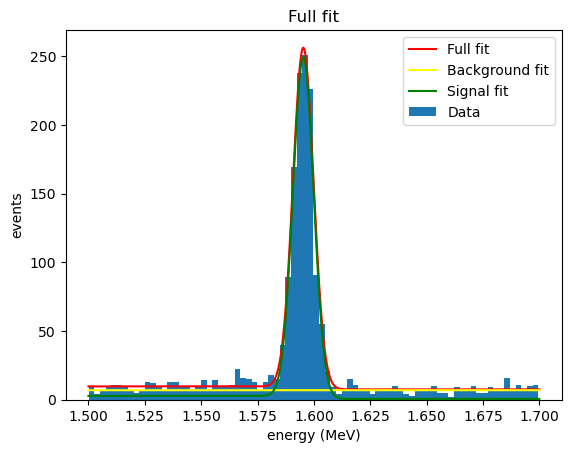

        Fitting output      
ns: 2.8399 ± 0.0372
a: 0.0088 ± 0.0223
nb: 6.9187 ± 17.4654
tau: 80772.4827 ± 10283218247.4996
ns - 1270.7613948718442
nb - 555.2466823452835
total = 1826
Event no = 1824
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 2615690.05 ± 179529787.70
Applying cut 0.05 MeV
=========================== GAUSSIAN FIT ============================


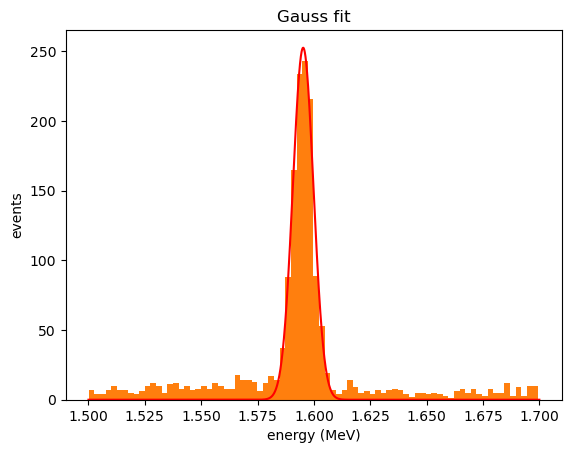

        Fitting output      
A: 252.5564 ± 5.9151
mu: 1.5952 ± 0.0001
sigma: 0.0046 ± 0.0001
=========================== FULL FIT ============================


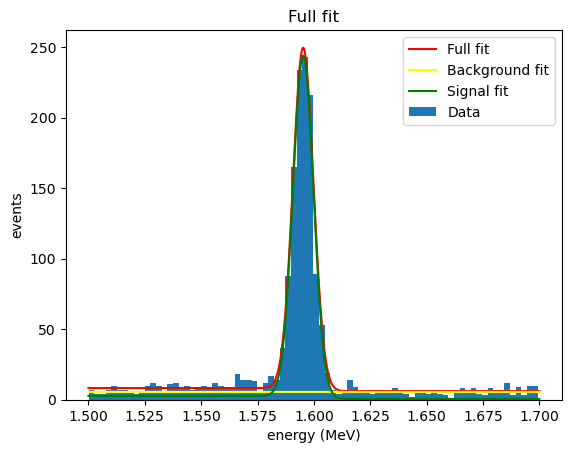

        Fitting output      
ns: 2.7740 ± 0.0333
a: 0.0087 ± 0.0204
nb: 5.5375 ± 15.7273
tau: -120120.6940 ± 25585608691.2120
ns - 1241.2364098585228
nb - 444.41755622593894
total = 1686
Event no = 1684
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 2093589.42 ± 143695038.37
Applying cut 0.06 MeV
=========================== GAUSSIAN FIT ============================


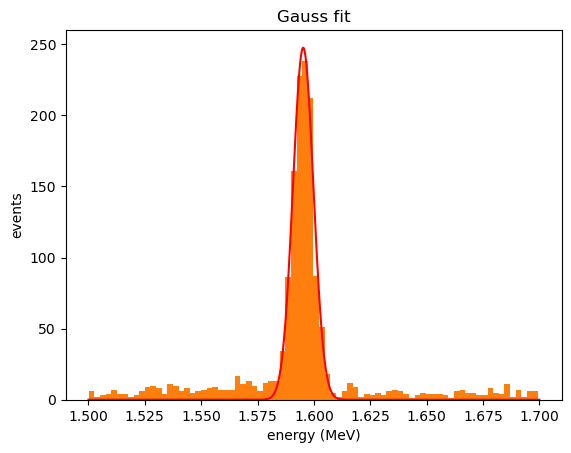

        Fitting output      
A: 247.5578 ± 5.0988
mu: 1.5952 ± 0.0001
sigma: 0.0045 ± 0.0001
=========================== FULL FIT ============================


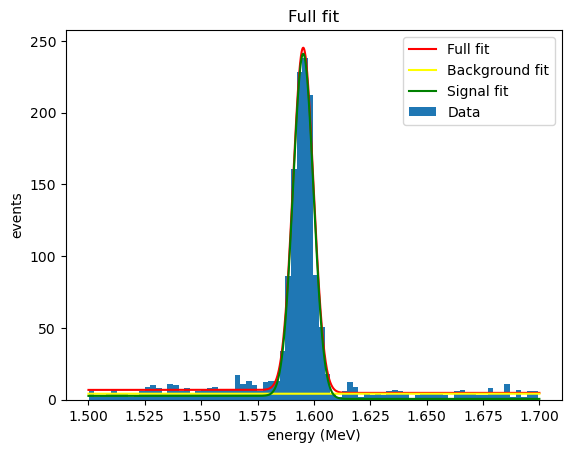

        Fitting output      
ns: 2.7217 ± 0.0318
a: 0.0087 ± 0.0198
nb: 4.1801 ± 14.9311
tau: 113548.1124 ± 28749336943.0850
ns - 1217.8337817351942
nb - 335.46811674836687
total = 1553
Event no = 1552
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 1580343.73 ± 108468054.36
Applying cut 0.07 MeV
=========================== GAUSSIAN FIT ============================


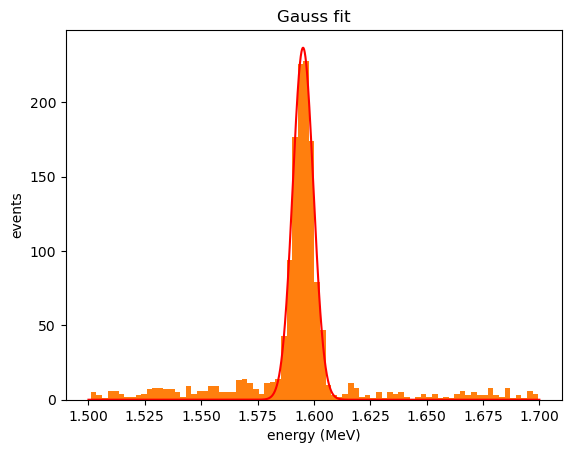

        Fitting output      
A: 236.8192 ± 3.9474
mu: 1.5952 ± 0.0001
sigma: 0.0046 ± 0.0001
=========================== FULL FIT ============================


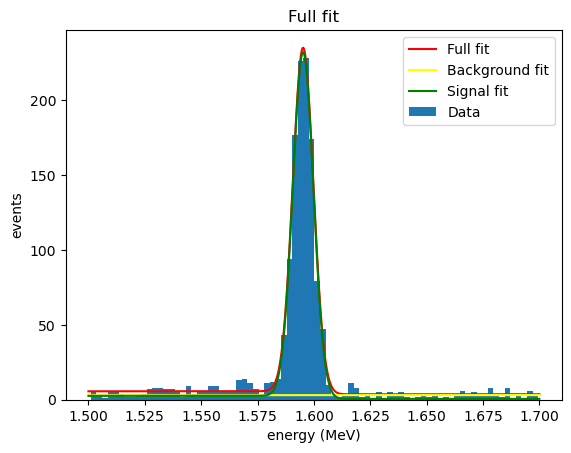

        Fitting output      
ns: 2.6482 ± 0.0236
a: 0.0088 ± 0.0151
nb: 2.6318 ± 9.5893
tau: -10.6286 ± 256.7863
ns - 1190.4383980975024
nb - 246.67348917585952
total = 1437
Event no = 1434
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 1162044.57 ± 79757792.60
Applying cut 0.08 MeV
=========================== GAUSSIAN FIT ============================


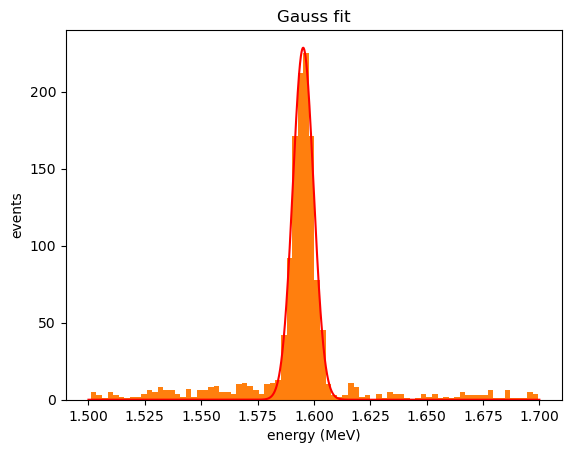

        Fitting output      
A: 228.4951 ± 3.5103
mu: 1.5952 ± 0.0001
sigma: 0.0046 ± 0.0001
=========================== FULL FIT ============================


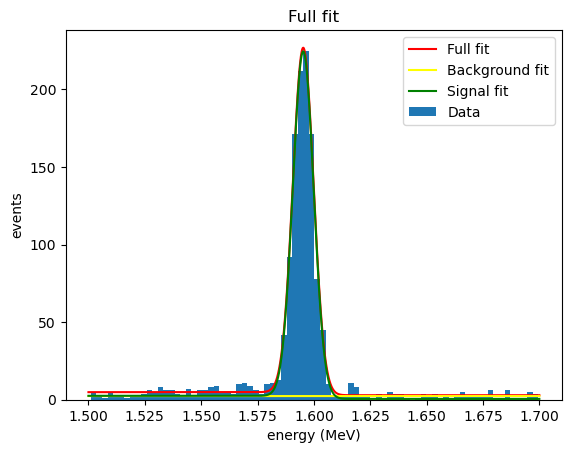

        Fitting output      
ns: 2.5821 ± 0.0230
a: 0.0088 ± 0.0151
nb: 2.3553 ± 10.6351
tau: 96089.9495 ± 26033333936.8733
ns - 1160.7450013310715
nb - 189.89947119543046
total = 1351
Event no = 1348
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 894590.05 ± 61400860.86
Applying cut 0.09 MeV
=========================== GAUSSIAN FIT ============================


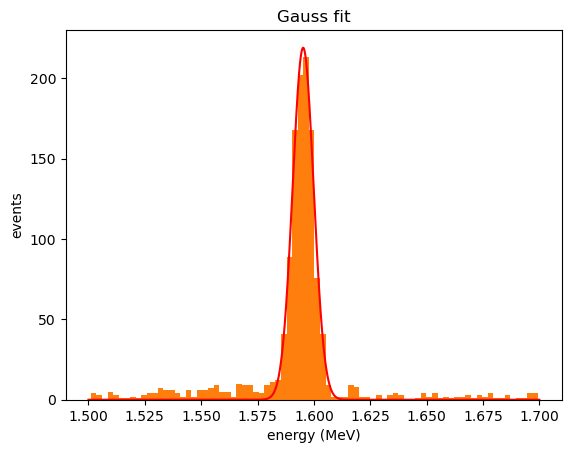

        Fitting output      
A: 219.0814 ± 3.2287
mu: 1.5952 ± 0.0001
sigma: 0.0047 ± 0.0001
=========================== FULL FIT ============================


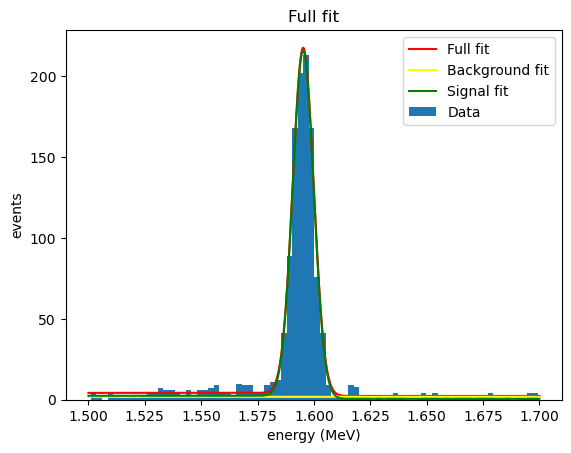

        Fitting output      
ns: 2.5004 ± 0.0230
a: 0.0089 ± 0.0156
nb: 1.8011 ± 10.7905
tau: -28463.3904 ± 3029268724.0443
ns - 1124.0329899779247
nb - 145.22664917734525
total = 1269
Event no = 1267
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 684142.59 ± 46956648.99
Applying cut 0.1 MeV
=========================== GAUSSIAN FIT ============================


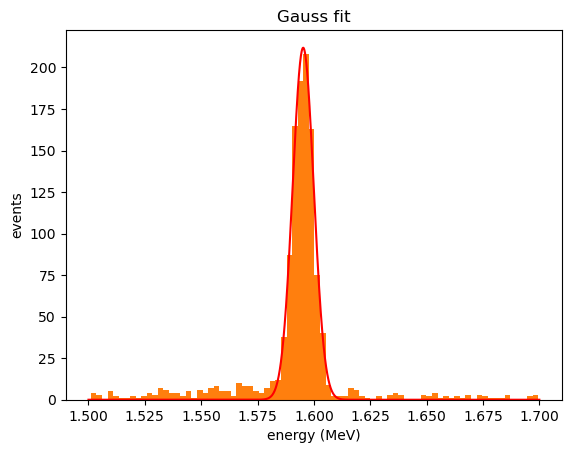

        Fitting output      
A: 211.9002 ± 3.0390
mu: 1.5952 ± 0.0001
sigma: 0.0047 ± 0.0001
=========================== FULL FIT ============================


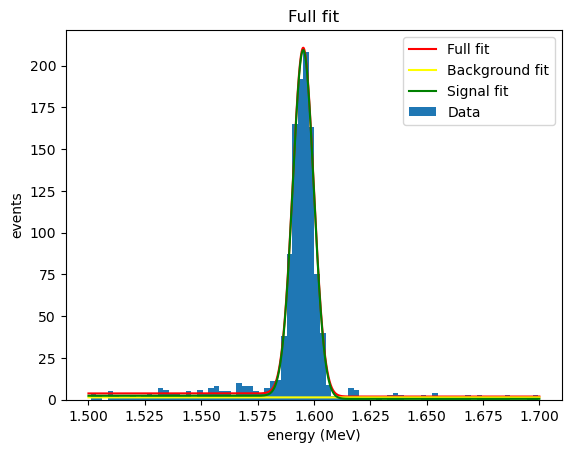

        Fitting output      
ns: 2.4354 ± 0.0231
a: 0.0089 ± 0.0162
nb: 1.3911 ± 10.6386
tau: -80275.2113 ± 30770535134.9835
ns - 1094.8079270962078
nb - 112.16480745989553
total = 1207
Event no = 1205
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 528392.84 ± 36266653.93
Applying cut 0.11 MeV
=========================== GAUSSIAN FIT ============================


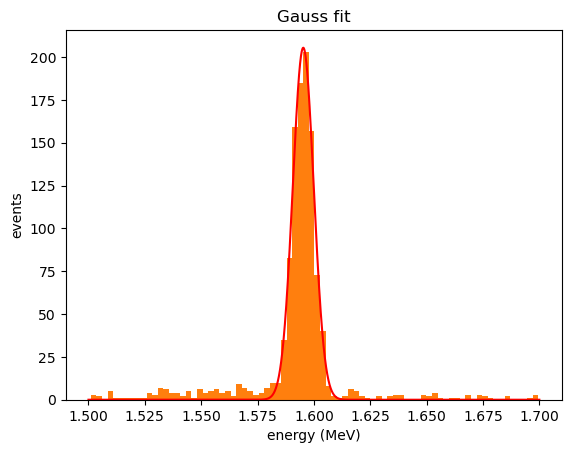

        Fitting output      
A: 205.4480 ± 2.7977
mu: 1.5953 ± 0.0001
sigma: 0.0046 ± 0.0001
=========================== FULL FIT ============================


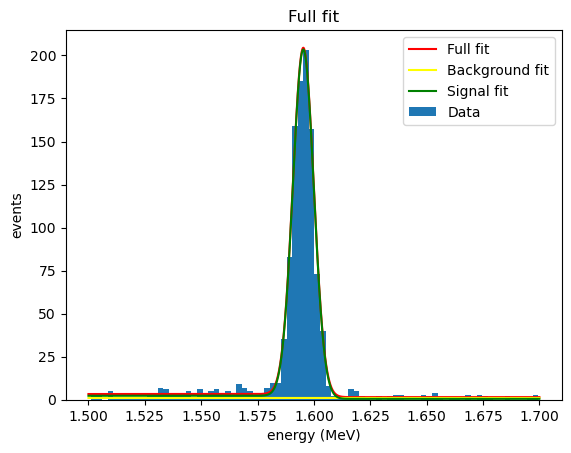

        Fitting output      
ns: 2.3529 ± 0.0221
a: 0.0089 ± 0.0159
nb: 1.0162 ± 10.2502
tau: -42262.8405 ± 11243554890.8143
ns - 1057.7645838701867
nb - 81.93570882202783
total = 1140
Event no = 1138
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 385987.75 ± 26492579.10
Applying cut 0.12 MeV
=========================== GAUSSIAN FIT ============================


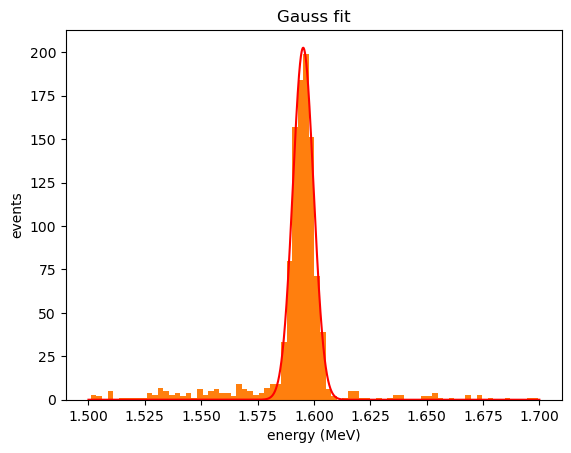

        Fitting output      
A: 202.6103 ± 2.6113
mu: 1.5952 ± 0.0001
sigma: 0.0046 ± 0.0001
=========================== FULL FIT ============================


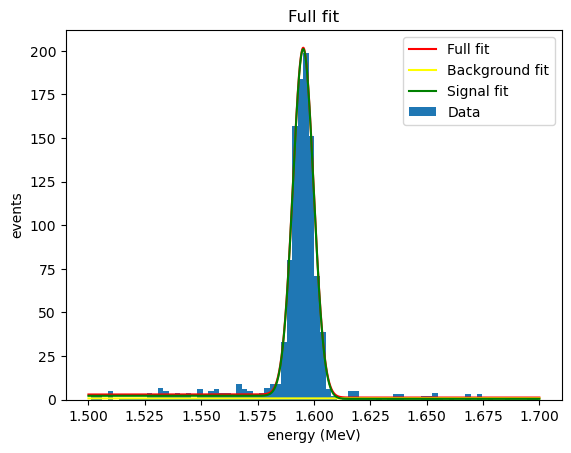

        Fitting output      
ns: 2.2975 ± 0.0206
a: 0.0088 ± 0.0153
nb: 0.7649 ± 8.2954
tau: -134934.1898 ± 122982930083.8894
ns - 1032.8416110303435
nb - 61.6756072503913
total = 1095
Event no = 1093
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 290545.22 ± 19941813.19
Applying cut 0.13 MeV
=========================== GAUSSIAN FIT ============================


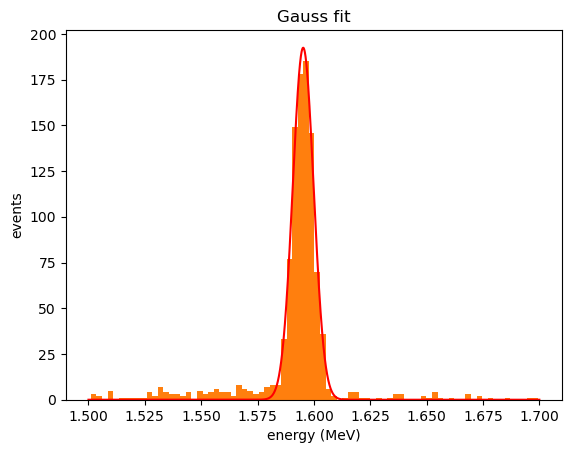

        Fitting output      
A: 192.4177 ± 2.3085
mu: 1.5952 ± 0.0001
sigma: 0.0046 ± 0.0001
=========================== FULL FIT ============================


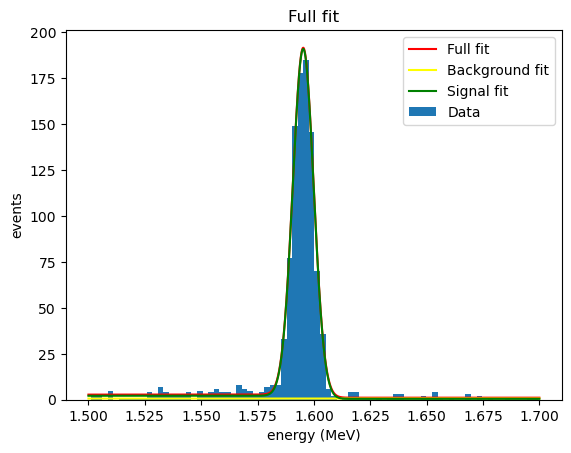

        Fitting output      
ns: 2.2014 ± 0.0180
a: 0.0089 ± 0.0139
nb: 0.6422 ± 8.3135
tau: -59764.1245 ± 28873601030.9218
ns - 989.6147106058442
nb - 51.78220426346512
total = 1041
Event no = 1040
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 243938.78 ± 16742946.35
Applying cut 0.14 MeV
=========================== GAUSSIAN FIT ============================


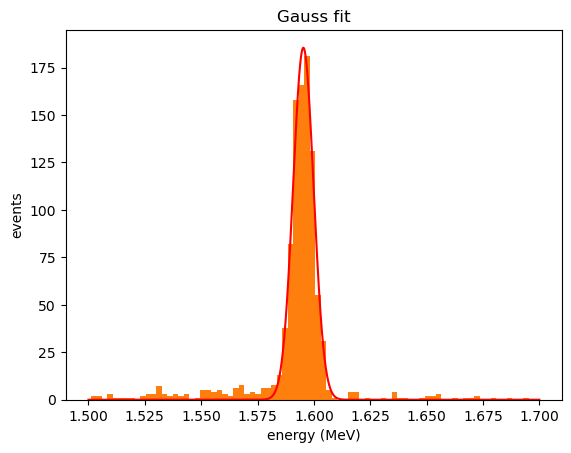

        Fitting output      
A: 185.4219 ± 2.7340
mu: 1.5953 ± 0.0001
sigma: 0.0045 ± 0.0001
=========================== FULL FIT ============================


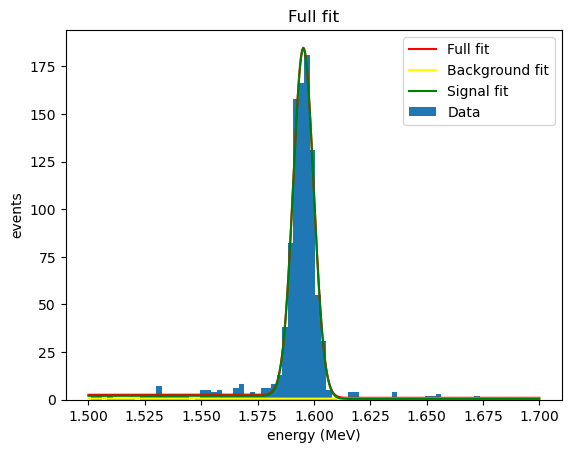

        Fitting output      
ns: 2.0850 ± 0.0232
a: 0.0087 ± 0.0189
nb: 0.5684 ± 11.3317
tau: -20557.7035 ± 5264841050.9565
ns - 957.2355742847499
nb - 46.80887641301869
total = 1004
Event no = 1001
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 220510.12 ± 15134903.75
Applying cut 0.15 MeV
=========================== GAUSSIAN FIT ============================


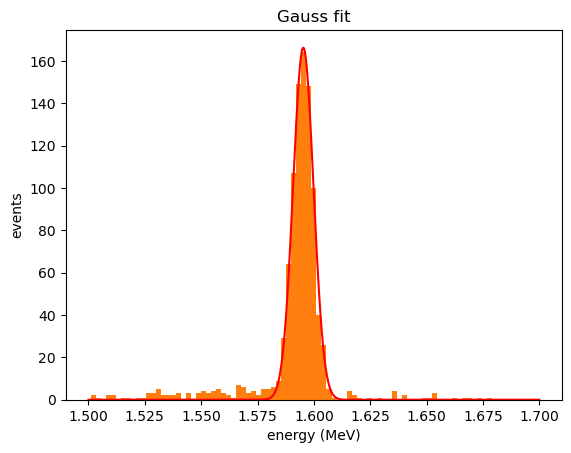

        Fitting output      
A: 166.2065 ± 1.8360
mu: 1.5953 ± 0.0001
sigma: 0.0045 ± 0.0001
=========================== FULL FIT ============================


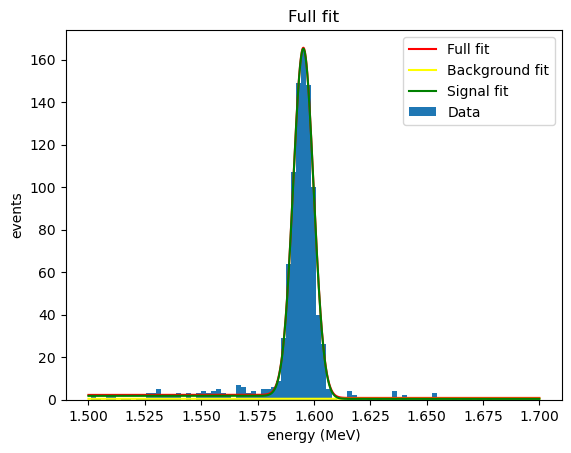

        Fitting output      
ns: 1.8602 ± 0.0140
a: 0.0087 ± 0.0127
nb: 0.4508 ± 7.7097
tau: 7474.5694 ± 600685317.1106
ns - 932.5156733112692
nb - 40.52050760109927
total = 973
Event no = 964
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 190886.49 ± 13101664.58
Applying cut 0.16 MeV
=========================== GAUSSIAN FIT ============================


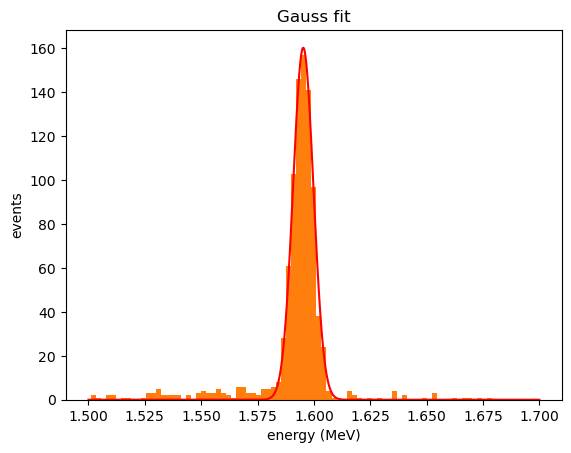

        Fitting output      
A: 160.3436 ± 1.7488
mu: 1.5953 ± 0.0001
sigma: 0.0045 ± 0.0001
=========================== FULL FIT ============================


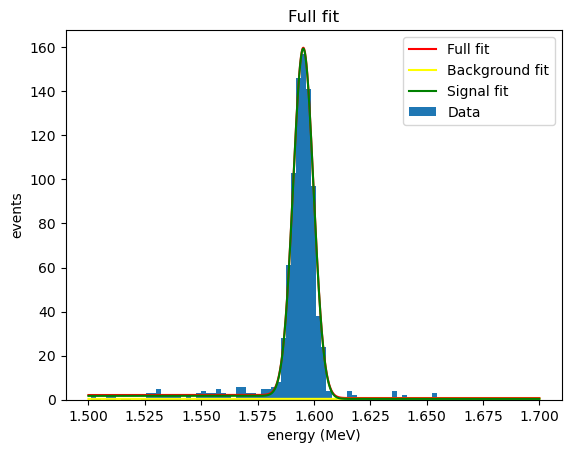

        Fitting output      
ns: 1.7880 ± 0.0134
a: 0.0086 ± 0.0127
nb: 0.3883 ± 7.3452
tau: 20765.5929 ± 5128574454.7932
ns - 896.3337802804514
nb - 34.90629421705696
total = 931
Event no = 923
fom - 0.00 ± 0.00
e - 0.01 ± 0.00
b - 164438.71 ± 11286402.33
Applying cut 0.17 MeV
=========================== GAUSSIAN FIT ============================


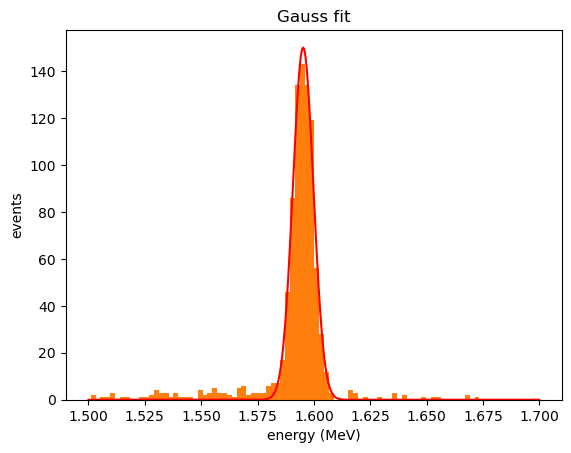

        Fitting output      
A: 149.9428 ± 1.9476
mu: 1.5952 ± 0.0001
sigma: 0.0045 ± 0.0001
=========================== FULL FIT ============================


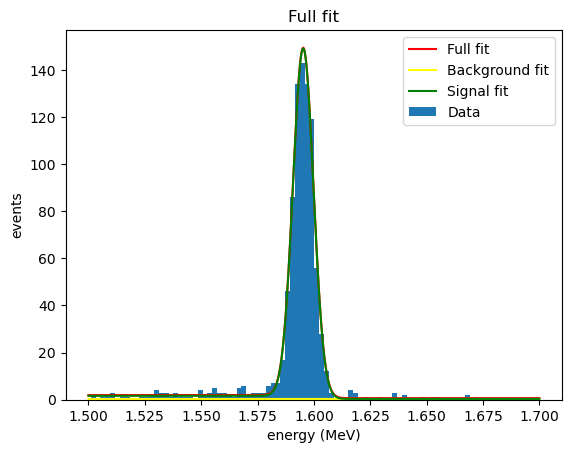

        Fitting output      
ns: 1.6878 ± 0.0166
a: 0.0087 ± 0.0166
nb: 0.3087 ± 9.5577
tau: 12155.4038 ± 2881279616.1023
ns - 873.5161899525398
nb - 28.65261341344008
total = 902
Event no = 893
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 134978.48 ± 9264378.95
Applying cut 0.18 MeV
=========================== GAUSSIAN FIT ============================


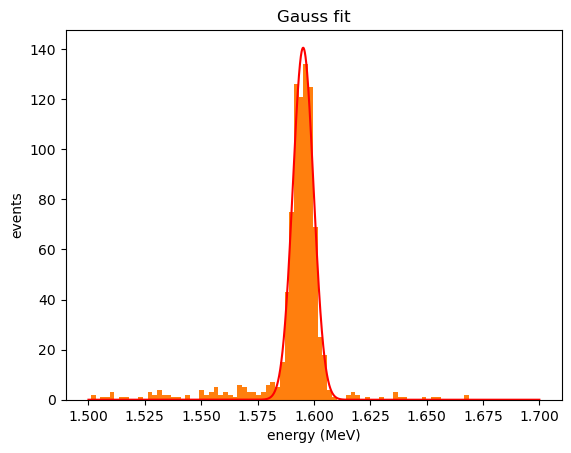

        Fitting output      
A: 140.5105 ± 2.4551
mu: 1.5952 ± 0.0001
sigma: 0.0046 ± 0.0001
=========================== FULL FIT ============================


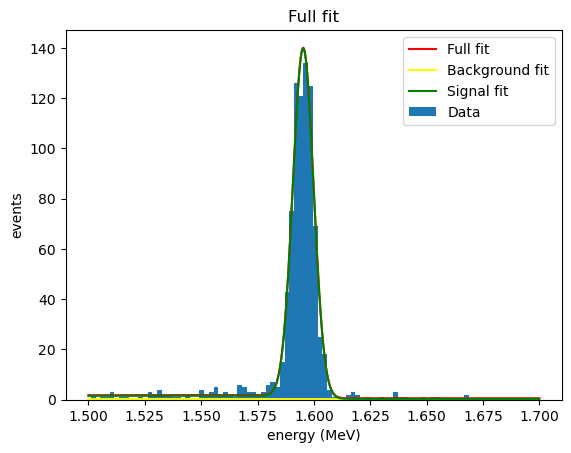

        Fitting output      
ns: 1.5992 ± 0.0229
a: 0.0088 ± 0.0240
nb: 0.2413 ± 13.5829
tau: 8093.7745 ± 2326485557.2875
ns - 850.5203258062571
nb - 23.015954087812965
total = 874
Event no = 864
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 108424.96 ± 7441859.17
Applying cut 0.19 MeV
=========================== GAUSSIAN FIT ============================


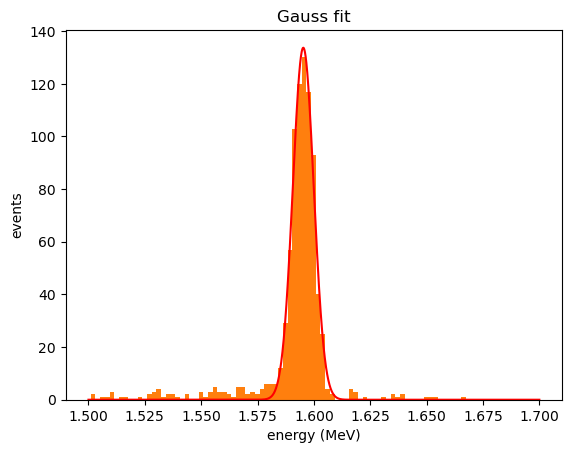

        Fitting output      
A: 133.7017 ± 1.7357
mu: 1.5953 ± 0.0001
sigma: 0.0046 ± 0.0001
=========================== FULL FIT ============================


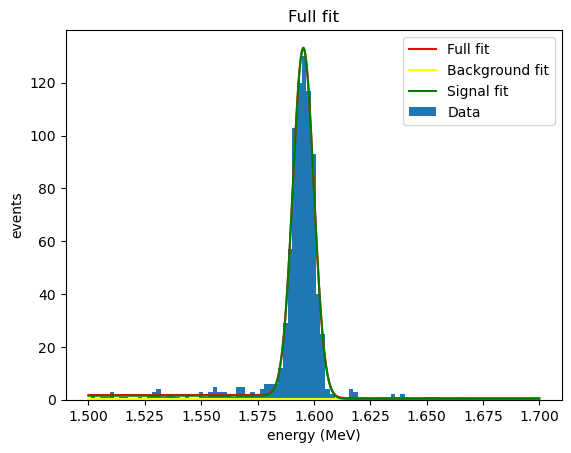

        Fitting output      
ns: 1.5307 ± 0.0151
a: 0.0088 ± 0.0166
nb: 0.2733 ± 8.8833
tau: 23349.6503 ± 11189727323.4315
ns - 820.9787280978202
nb - 26.28521888251911
total = 847
Event no = 837
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 123826.02 ± 8498921.41
Applying cut 0.2 MeV
=========================== GAUSSIAN FIT ============================


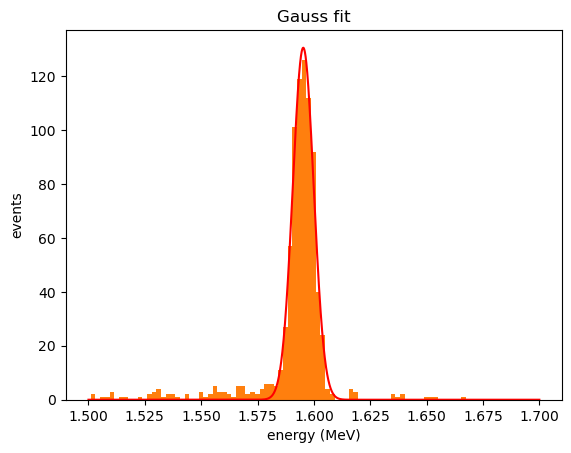

        Fitting output      
A: 130.5137 ± 1.7181
mu: 1.5953 ± 0.0001
sigma: 0.0046 ± 0.0001
=========================== FULL FIT ============================


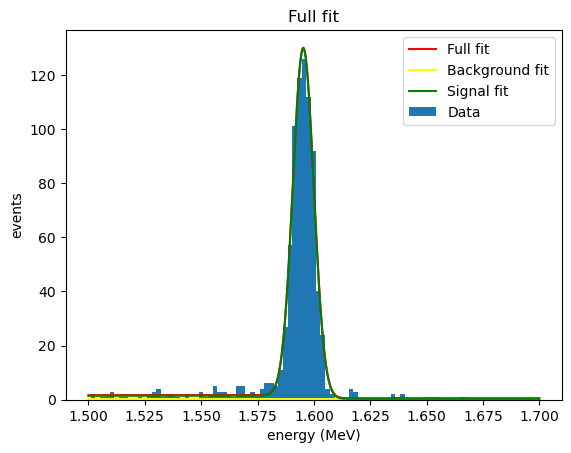

        Fitting output      
ns: 1.4976 ± 0.0151
a: 0.0089 ± 0.0169
nb: 0.2311 ± 9.0484
tau: 3709.7134 ± 340091291.0231
ns - 803.2294470197983
nb - 22.22408998440371
total = 825
Event no = 816
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 104694.60 ± 7185823.12
Applying cut 0.21 MeV
=========================== GAUSSIAN FIT ============================


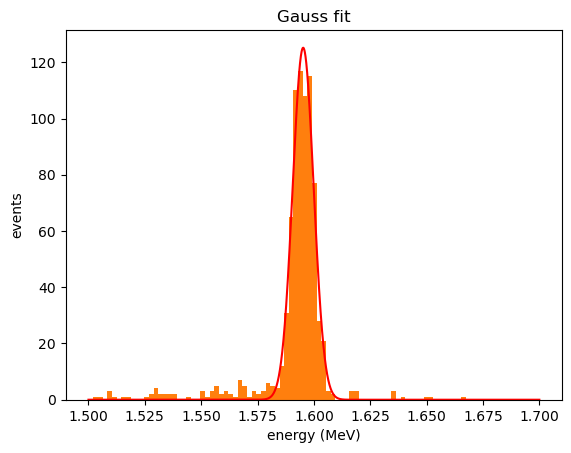

        Fitting output      
A: 125.1926 ± 2.2811
mu: 1.5952 ± 0.0001
sigma: 0.0046 ± 0.0001
=========================== FULL FIT ============================


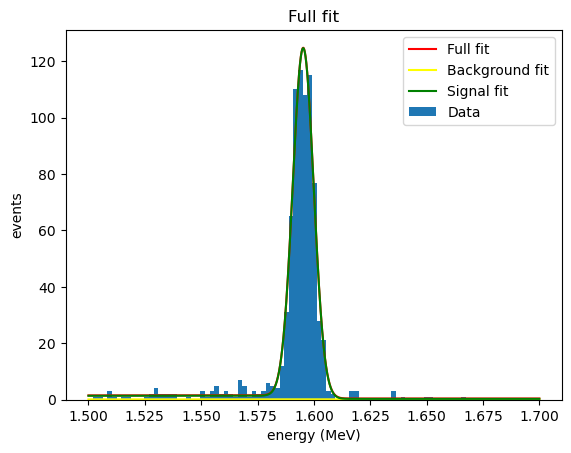

        Fitting output      
ns: 1.4405 ± 0.0218
a: 0.0089 ± 0.0275
nb: 0.1321 ± 3.8543
tau: -168064.0638 ± 520423121984.0554
ns - 777.7065660928855
nb - 12.796530600270996
total = 791
Event no = 782
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 60282.68 ± 4137579.04
Applying cut 0.22 MeV
=========================== GAUSSIAN FIT ============================


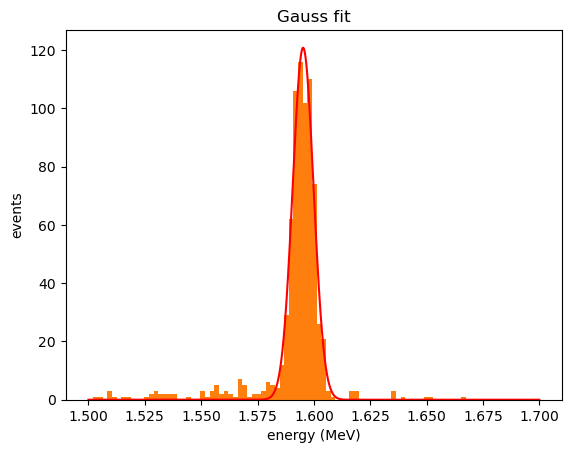

        Fitting output      
A: 120.8275 ± 2.2763
mu: 1.5952 ± 0.0001
sigma: 0.0046 ± 0.0001
=========================== FULL FIT ============================


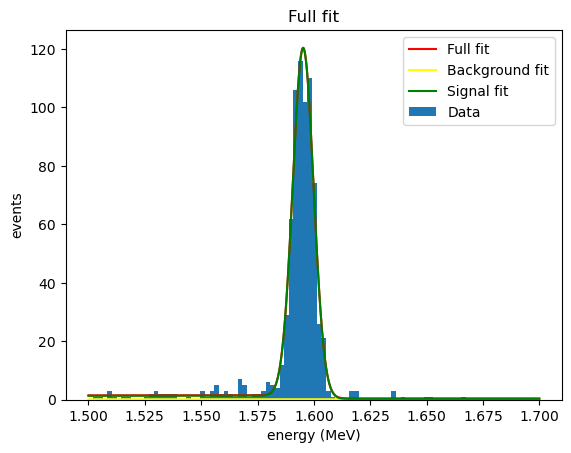

        Fitting output      
ns: 1.3834 ± 0.0216
a: 0.0088 ± 0.0263
nb: 0.1520 ± 13.1496
tau: 953.8465 ± 49657521.0749
ns - 746.8855480308713
nb - 14.69748182088476
total = 762
Event no = 753
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 69237.80 ± 4752219.91
Applying cut 0.23 MeV
=========================== GAUSSIAN FIT ============================


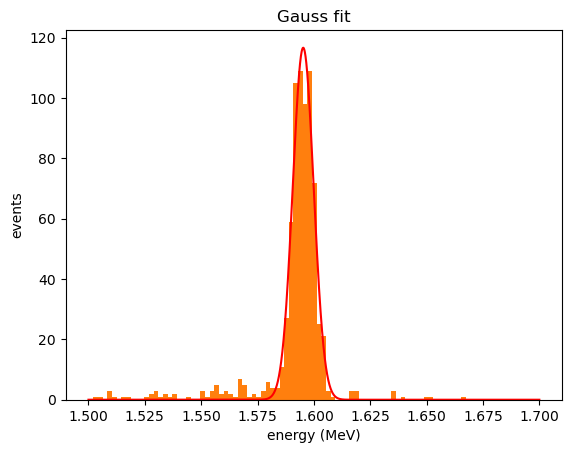

        Fitting output      
A: 116.6760 ± 2.4080
mu: 1.5953 ± 0.0001
sigma: 0.0046 ± 0.0001
=========================== FULL FIT ============================


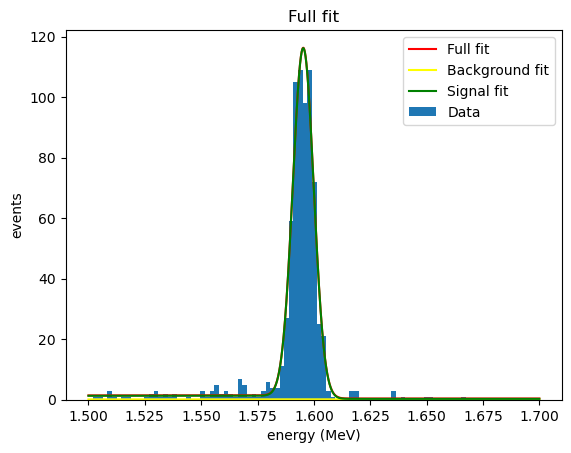

        Fitting output      
ns: 1.3391 ± 0.0416
a: 0.0089 ± 0.0314
nb: 0.1231 ± 4.6436
tau: -168064.0628 ± 681588756756.1971
ns - 722.9866035222809
nb - 11.922778612278844
total = 735
Event no = 727
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 56166.56 ± 3855065.91
Applying cut 0.24 MeV
=========================== GAUSSIAN FIT ============================


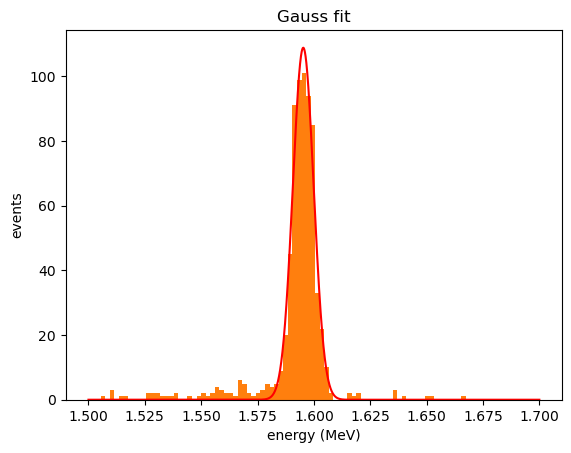

        Fitting output      
A: 108.8661 ± 1.9813
mu: 1.5953 ± 0.0001
sigma: 0.0046 ± 0.0001
=========================== FULL FIT ============================


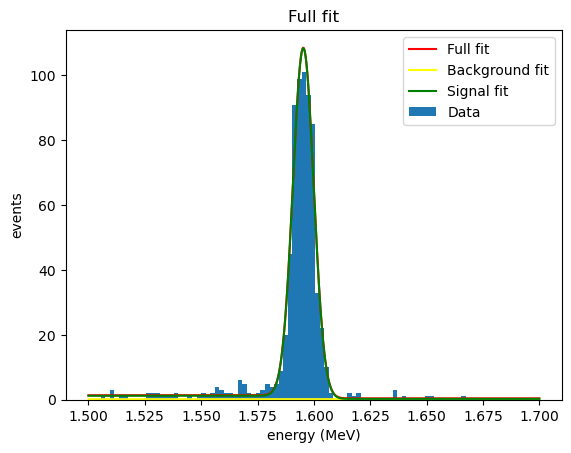

        Fitting output      
ns: 1.2460 ± 0.0189
a: 0.0088 ± 0.0253
nb: 0.1621 ± 11.7599
tau: 5449.1681 ± 1358249983.8684
ns - 686.5817222229972
nb - 16.01345144374495
total = 703
Event no = 692
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 75437.15 ± 5177716.74
Applying cut 0.25 MeV
=========================== GAUSSIAN FIT ============================


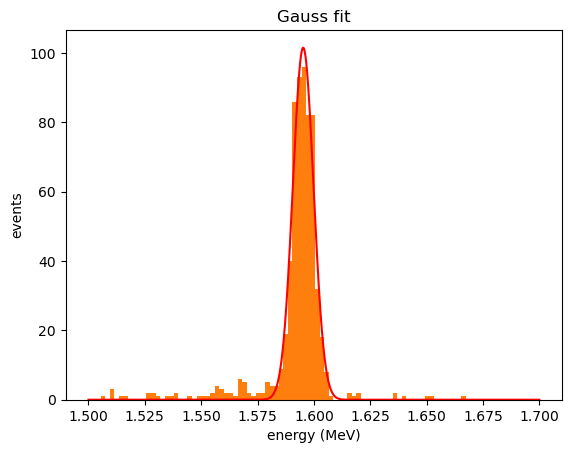

        Fitting output      
A: 101.5411 ± 2.0373
mu: 1.5952 ± 0.0001
sigma: 0.0046 ± 0.0001
=========================== FULL FIT ============================


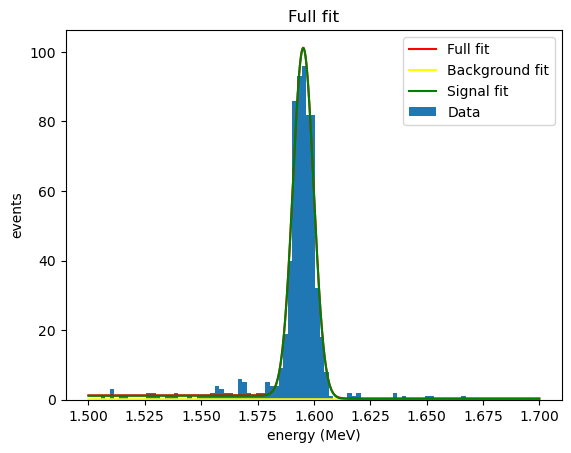

        Fitting output      
ns: 1.1571 ± 0.0195
a: 0.0088 ± 0.0283
nb: 0.1303 ± 12.2159
tau: 983.4450 ± 57168631.4105
ns - 637.6012105928972
nb - 12.853497580031094
total = 650
Event no = 641
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 60551.04 ± 4155998.37
Applying cut 0.26 MeV
=========================== GAUSSIAN FIT ============================


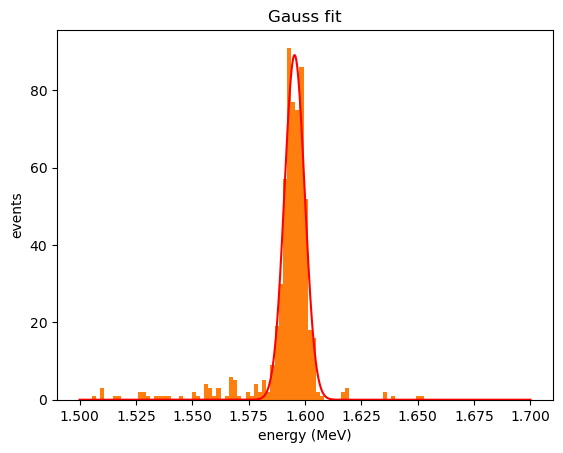

        Fitting output      
A: 89.0976 ± 2.1748
mu: 1.5954 ± 0.0001
sigma: 0.0045 ± 0.0001
=========================== FULL FIT ============================


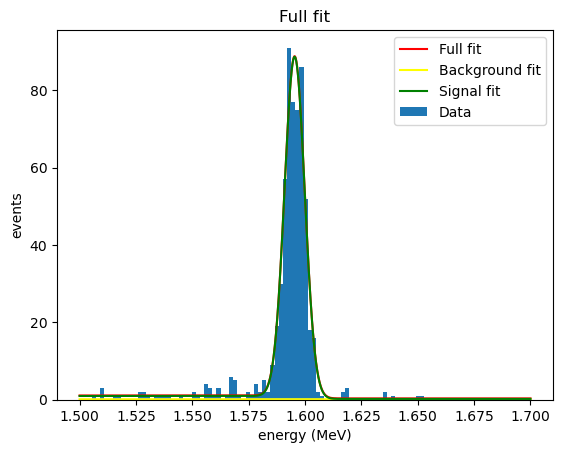

        Fitting output      
ns: 0.9903 ± 0.0207
a: 0.0086 ± 0.0349
nb: 0.1321 ± 15.0485
tau: 1552.9529 ± 174053824.8075
ns - 599.6909774188082
nb - 14.336714853913508
total = 614
Event no = 602
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 67538.27 ± 4635571.93
Applying cut 0.27 MeV
=========================== GAUSSIAN FIT ============================


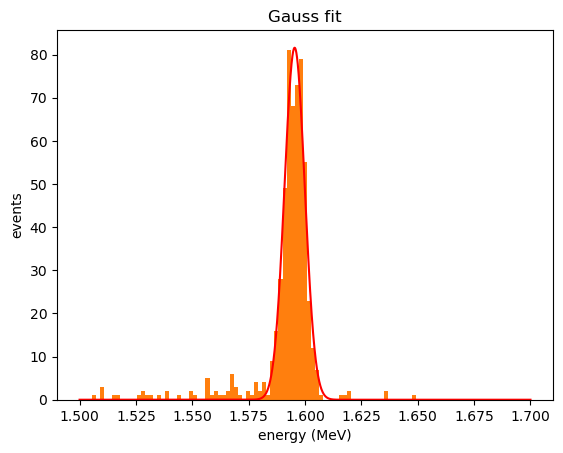

        Fitting output      
A: 81.6056 ± 1.8224
mu: 1.5954 ± 0.0001
sigma: 0.0045 ± 0.0001
=========================== FULL FIT ============================


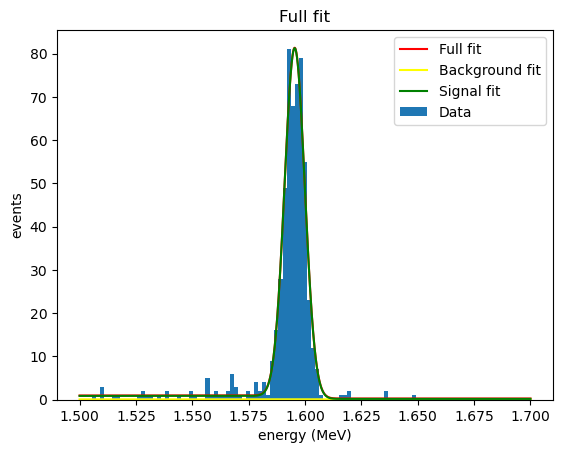

        Fitting output      
ns: 0.9078 ± 0.0174
a: 0.0086 ± 0.0317
nb: 0.0923 ± 13.0925
tau: 215.6411 ± 4186084.3735
ns - 562.7788804547024
nb - 10.184913772949646
total = 573
Event no = 562
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 47979.72 ± 3293156.30
Applying cut 0.28 MeV
=========================== GAUSSIAN FIT ============================


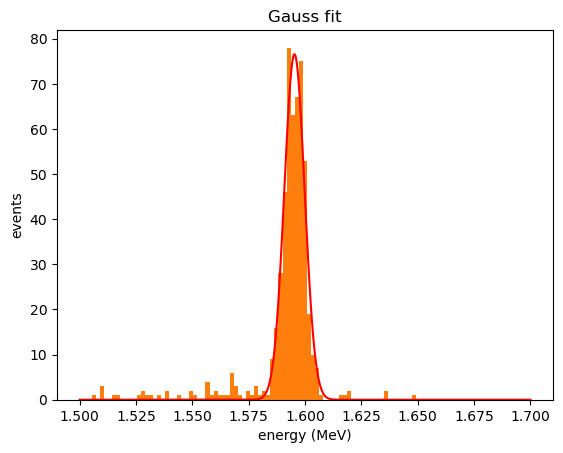

        Fitting output      
A: 76.5628 ± 1.9034
mu: 1.5953 ± 0.0001
sigma: 0.0045 ± 0.0001
=========================== FULL FIT ============================


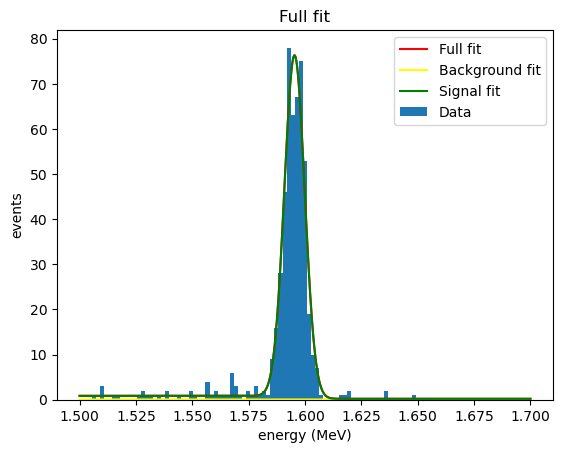

        Fitting output      
ns: 0.8561 ± 0.0185
a: 0.0086 ± 0.0376
nb: 0.0492 ± 1.1993
tau: -252107.9493 ± 939379823289.0416
ns - 530.7129635859288
nb - 5.468044414137425
total = 536
Event no = 527
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 25759.20 ± 1768035.27
Applying cut 0.29 MeV
=========================== GAUSSIAN FIT ============================


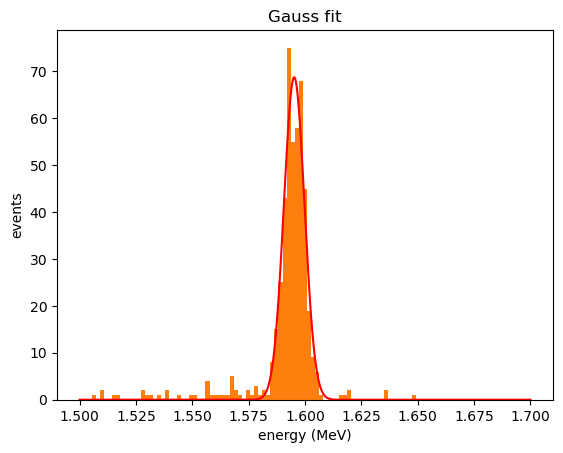

        Fitting output      
A: 68.6936 ± 1.8903
mu: 1.5952 ± 0.0001
sigma: 0.0046 ± 0.0001
=========================== FULL FIT ============================


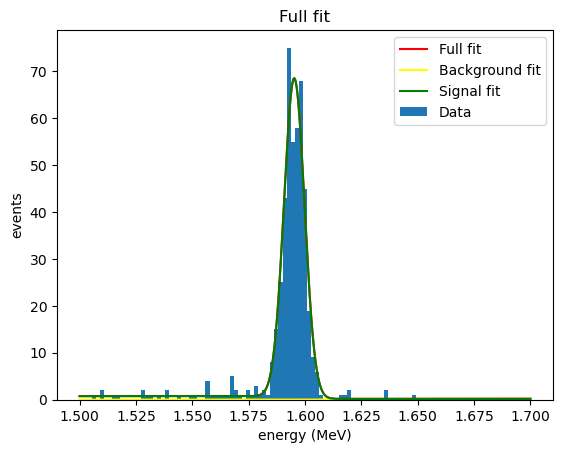

        Fitting output      
ns: 0.7768 ± 0.0187
a: 0.0087 ± 0.0398
nb: 0.0000 ± 0.0000
tau: -0.0972 ± 4.3028
ns - 481.49642629696865
nb - 3.300851373297893
total = 485
Event no = 476
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 15549.85 ± 1067309.55
Applying cut 0.3 MeV
=========================== GAUSSIAN FIT ============================


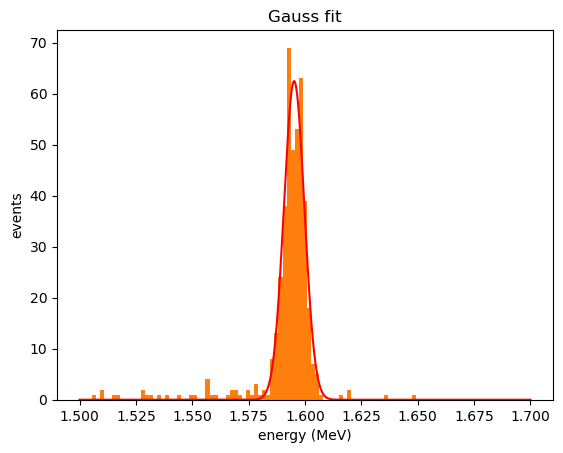

        Fitting output      
A: 62.4510 ± 1.7809
mu: 1.5952 ± 0.0001
sigma: 0.0045 ± 0.0001
=========================== FULL FIT ============================


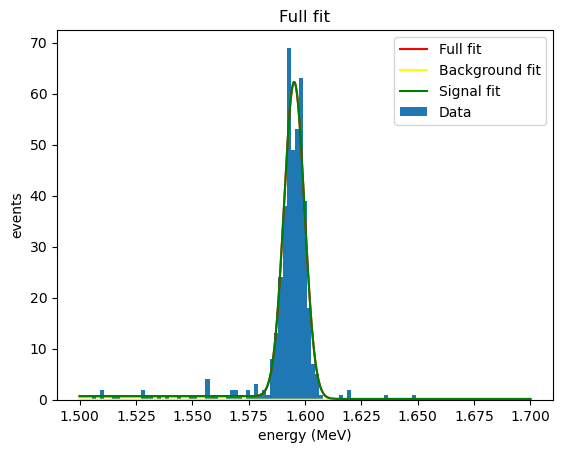

        Fitting output      
ns: 0.7045 ± 0.0174
a: 0.0087 ± 0.0413
nb: 0.0000 ± 0.3658
tau: -84020.1645 ± 0.0000
ns - 436.64066050282497
nb - 3.902104153574947e-05
total = 437
Event no = 428
fom - 0.01 ± 0.50
e - 0.00 ± 0.00
b - 0.18 ± 32.02
Applying cut 0.31 MeV
=========================== GAUSSIAN FIT ============================


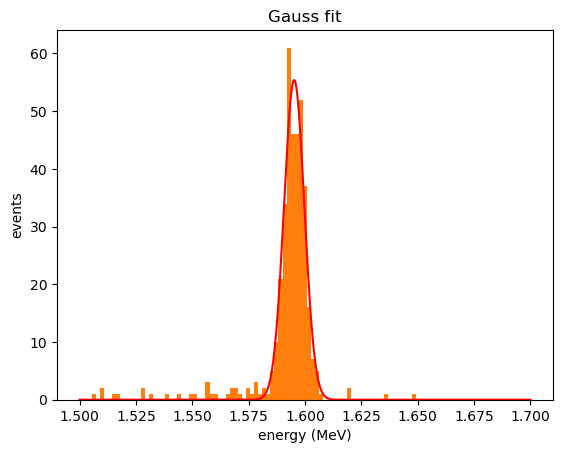

        Fitting output      
A: 55.3939 ± 1.4507
mu: 1.5952 ± 0.0001
sigma: 0.0045 ± 0.0001
=========================== FULL FIT ============================


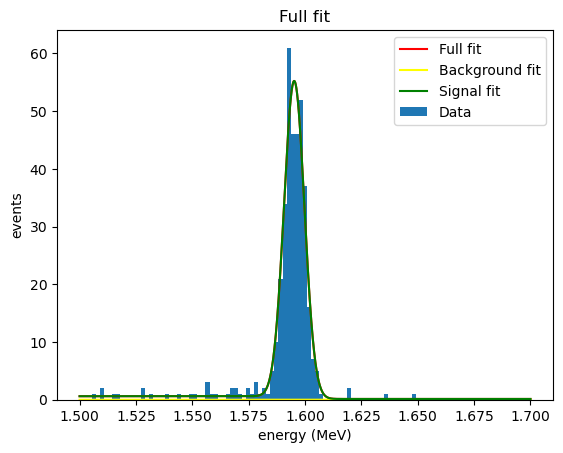

        Fitting output      
ns: 0.6215 ± 0.0141
a: 0.0086 ± 0.0378
nb: 0.0000 ± 0.2963
tau: -3161.1223 ± 0.0000
ns - 385.2326393638274
nb - 1.271502229764524e-13
total = 385
Event no = 378
fom - 87.94 ± 123310537.63
e - 0.00 ± 0.00
b - 0.00 ± 0.00
Applying cut 0.32 MeV
=========================== GAUSSIAN FIT ============================


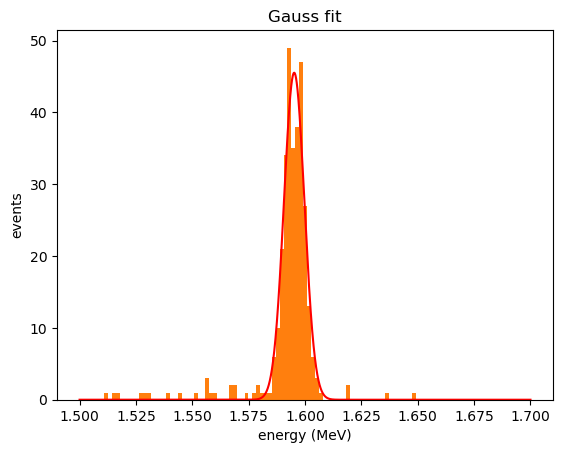

        Fitting output      
A: 45.5197 ± 1.2898
mu: 1.5952 ± 0.0001
sigma: 0.0045 ± 0.0001
=========================== FULL FIT ============================


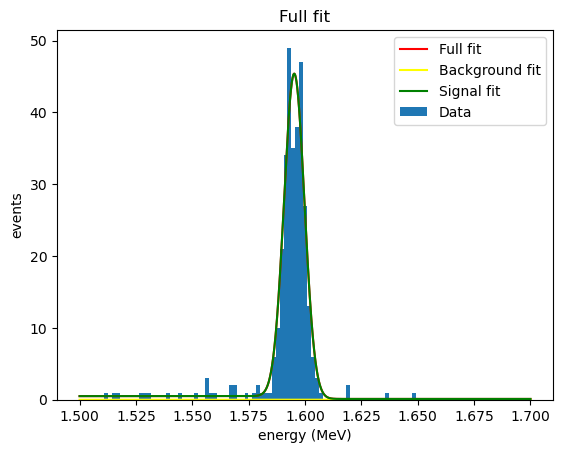

        Fitting output      
ns: 0.5119 ± 0.0127
a: 0.0087 ± 0.0412
nb: 0.0000 ± 0.2711
tau: -2757.0629 ± 0.0000
ns - 329.50580223958207
nb - 7.218731146674363e-12
total = 330
Event no = 319
fom - 9.98 ± 1857789.26
e - 0.00 ± 0.00
b - 0.00 ± 0.01
Applying cut 0.33 MeV
=========================== GAUSSIAN FIT ============================


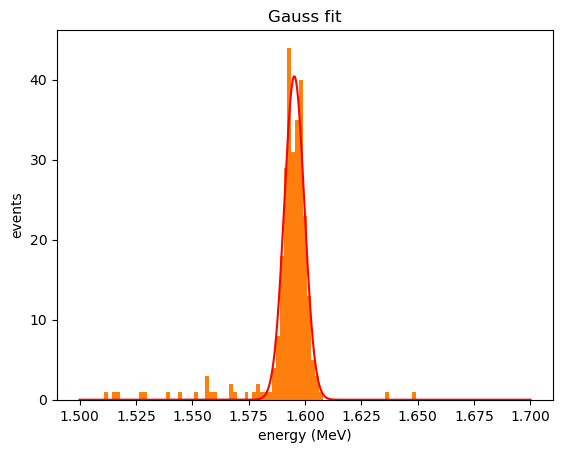

        Fitting output      
A: 40.4289 ± 1.0862
mu: 1.5952 ± 0.0001
sigma: 0.0045 ± 0.0001
=========================== FULL FIT ============================


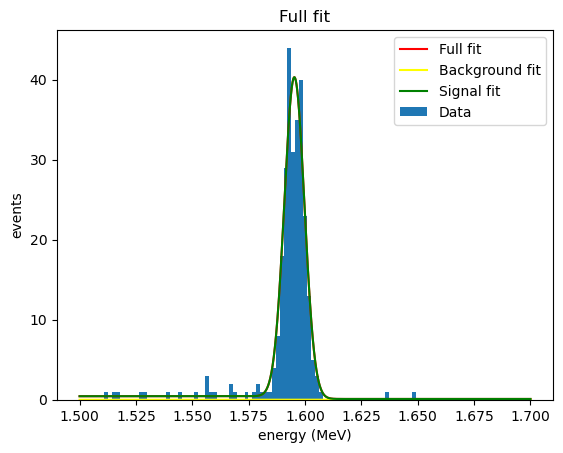

        Fitting output      
ns: 0.4478 ± 0.0105
a: 0.0085 ± 0.0390
nb: 0.0000 ± 0.2259
tau: -3030.8887 ± 0.0000
ns - 288.2059523130305
nb - 8.015747258244454e-14
total = 288
Event no = 279
fom - 82.86 ± 146336671.31
e - 0.00 ± 0.00
b - 0.00 ± 0.00
Applying cut 0.34 MeV
=========================== GAUSSIAN FIT ============================


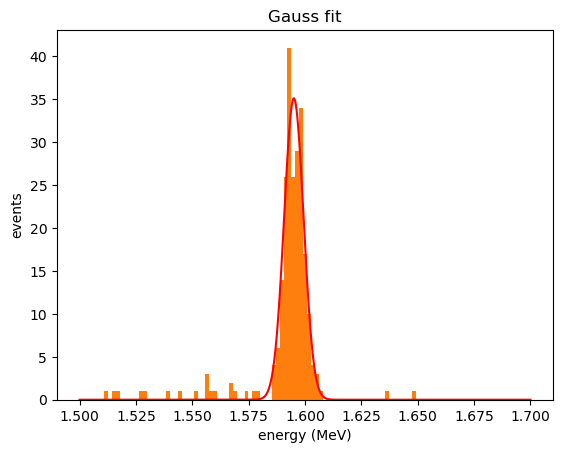

        Fitting output      
A: 35.1036 ± 1.1368
mu: 1.5950 ± 0.0002
sigma: 0.0043 ± 0.0002
=========================== FULL FIT ============================


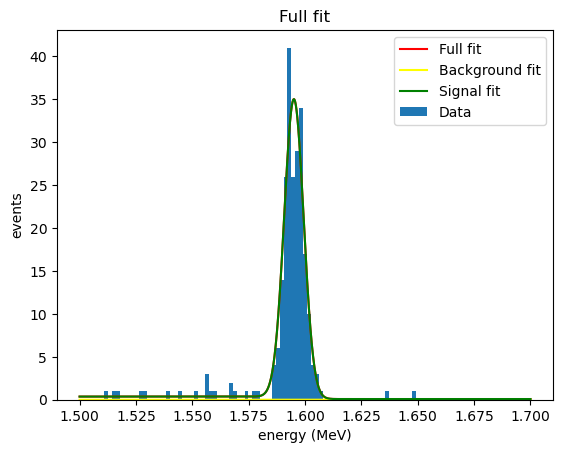

        Fitting output      
ns: 0.3755 ± 0.0106
a: 0.0082 ± 0.0472
nb: 0.0000 ± 0.2326
tau: -1992.0365 ± 0.0000
ns - 241.6833130999471
nb - 9.542078410200389e-10
total = 242
Event no = 236
fom - 0.64 ± 10308.58
e - 0.00 ± 0.00
b - 0.00 ± 0.15
Applying cut 0.35000000000000003 MeV
=========================== GAUSSIAN FIT ============================


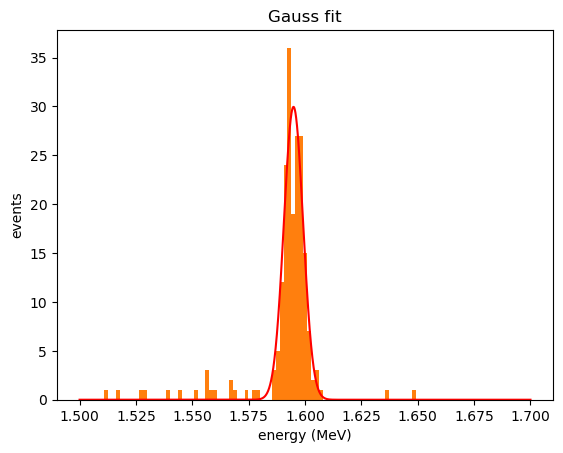

        Fitting output      
A: 29.9532 ± 1.1174
mu: 1.5949 ± 0.0002
sigma: 0.0043 ± 0.0002
=========================== FULL FIT ============================


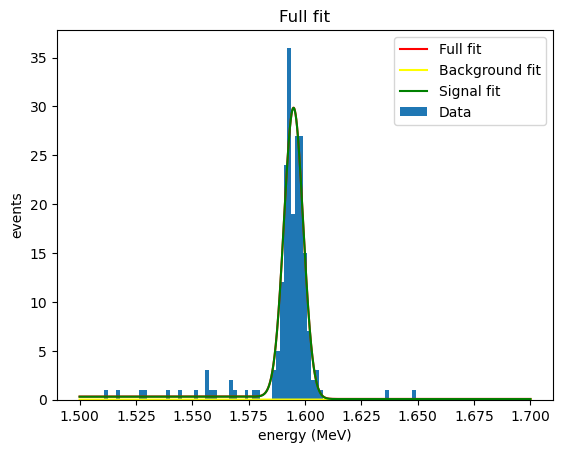

        Fitting output      
ns: 0.3164 ± 0.0103
a: 0.0081 ± 0.0544
nb: 0.0159 ± 0.2274
tau: -2689380.7994 ± 0.0000
ns - 203.61418121155845
nb - 1.8301656063056555
total = 205
Event no = 201
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 8621.66 ± 591787.84
Applying cut 0.36 MeV
=========================== GAUSSIAN FIT ============================


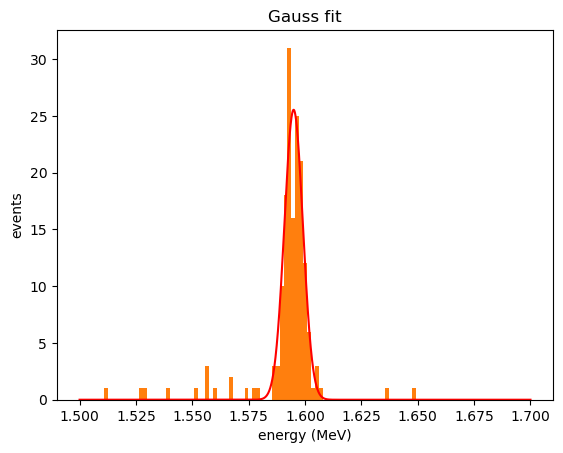

        Fitting output      
A: 25.5348 ± 0.9764
mu: 1.5949 ± 0.0002
sigma: 0.0041 ± 0.0002
=========================== FULL FIT ============================


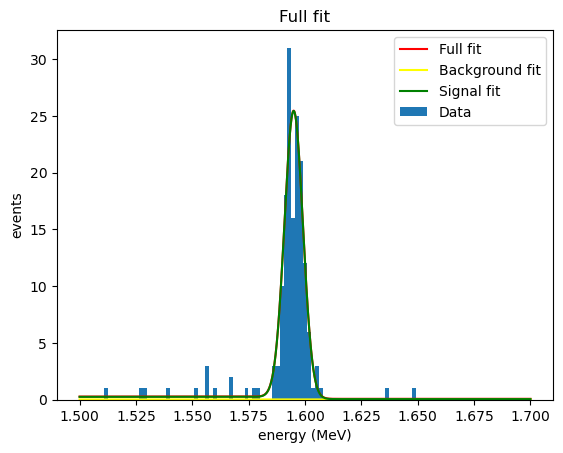

        Fitting output      
ns: 0.2598 ± 0.0087
a: 0.0078 ± 0.0558
nb: 0.0252 ± 0.1946
tau: -672369.0801 ± 0.0000
ns - 167.17122487812065
nb - 2.9094892900023464
total = 170
Event no = 166
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 13706.20 ± 940769.15
Applying cut 0.37 MeV
=========================== GAUSSIAN FIT ============================


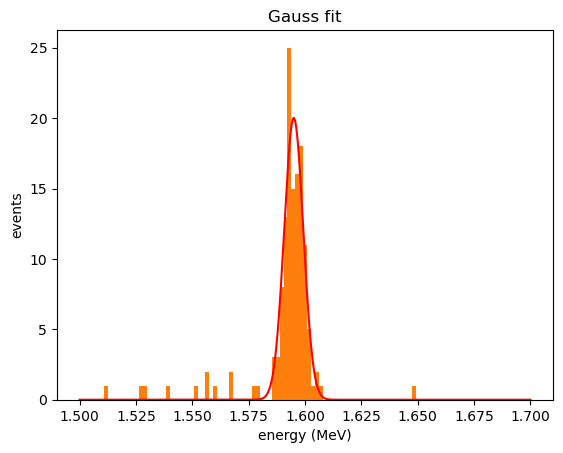

        Fitting output      
A: 20.0092 ± 0.7341
mu: 1.5950 ± 0.0002
sigma: 0.0042 ± 0.0002
=========================== FULL FIT ============================


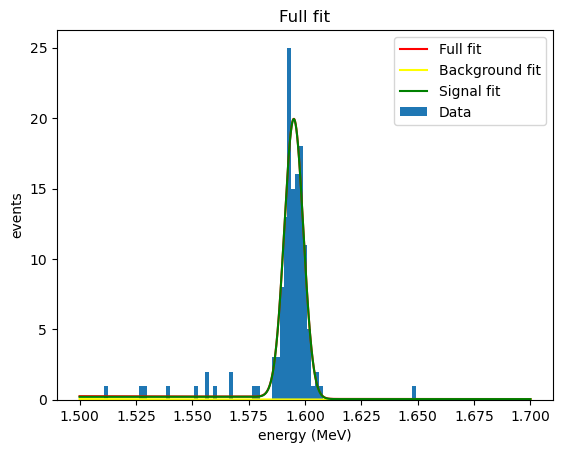

        Fitting output      
ns: 0.2098 ± 0.0069
a: 0.0082 ± 0.0534
nb: 4702283.8391 ± 1507905892.7220
tau: 0.0816 ± 1.3827
ns - 135.01041045941835
nb - 2.102690933031
total = 137
Event no = 134
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 9905.49 ± 679904.36
Applying cut 0.38 MeV
=========================== GAUSSIAN FIT ============================


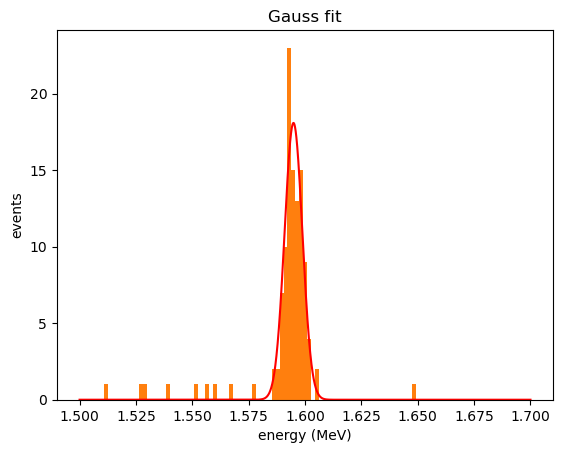

        Fitting output      
A: 18.0869 ± 0.6881
mu: 1.5949 ± 0.0002
sigma: 0.0039 ± 0.0002
=========================== FULL FIT ============================


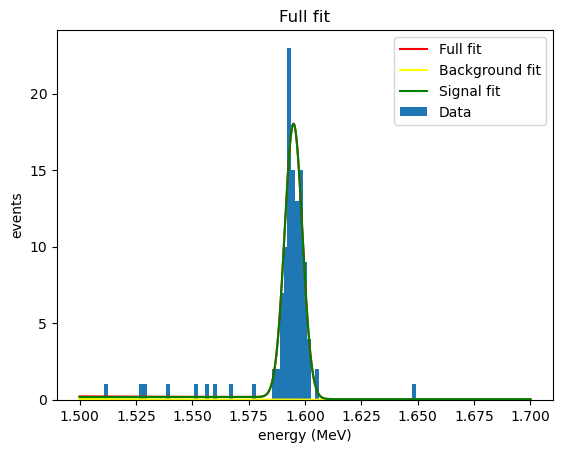

        Fitting output      
ns: 0.1770 ± 0.0056
a: 0.0078 ± 0.0555
nb: 2694776380710.8892 ± 0.0000
tau: 0.0474 ± 0.0115
ns - 113.87394151656372
nb - 1.3307704108261371
total = 115
Event no = 112
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 6269.07 ± 430316.73
Applying cut 0.39 MeV
=========================== GAUSSIAN FIT ============================


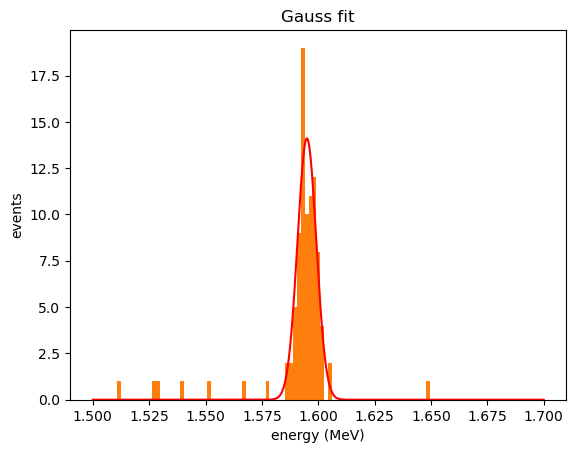

        Fitting output      
A: 14.1088 ± 0.6122
mu: 1.5950 ± 0.0002
sigma: 0.0042 ± 0.0002
=========================== FULL FIT ============================


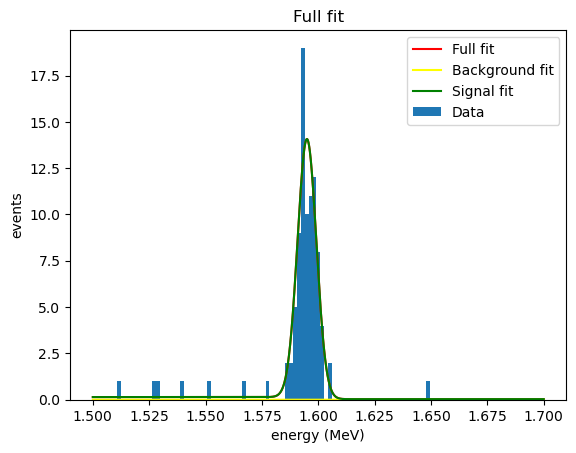

        Fitting output      
ns: 0.1463 ± 0.0056
a: 0.0080 ± 0.0635
nb: 0.0000 ± 0.1237
tau: -2779.1221 ± 0.0000
ns - 94.13517908692604
nb - 6.291041861361519e-12
total = 94
Event no = 92
fom - 3.06 ± 609008.88
e - 0.00 ± 0.00
b - 0.00 ± 0.01
Applying cut 0.4 MeV
=========================== GAUSSIAN FIT ============================


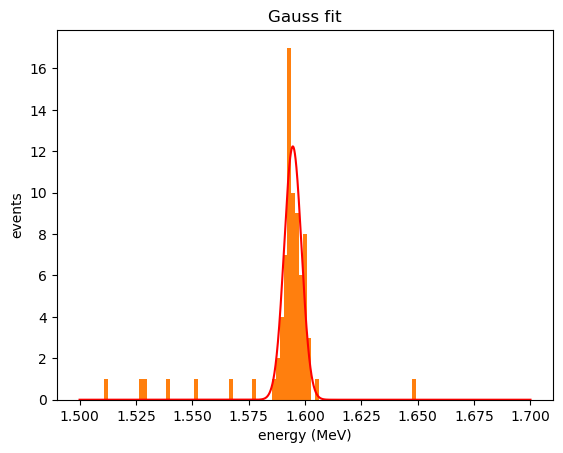

        Fitting output      
A: 12.2354 ± 0.5887
mu: 1.5946 ± 0.0002
sigma: 0.0038 ± 0.0002
=========================== FULL FIT ============================


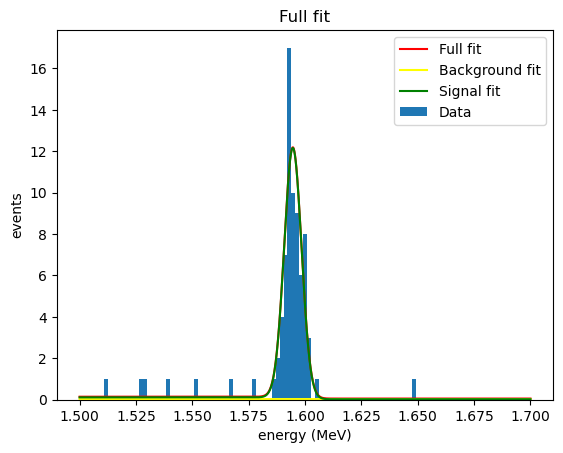

        Fitting output      
ns: 0.1164 ± 0.0049
a: 0.0073 ± 0.0706
nb: 0.0320 ± 4.2335
tau: -6006.3792 ± 3025777269.8236
ns - 74.87031160382243
nb - 3.6908233200967775
total = 79
Event no = 76
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 17386.96 ± 1193400.48
Applying cut 0.41000000000000003 MeV
=========================== GAUSSIAN FIT ============================


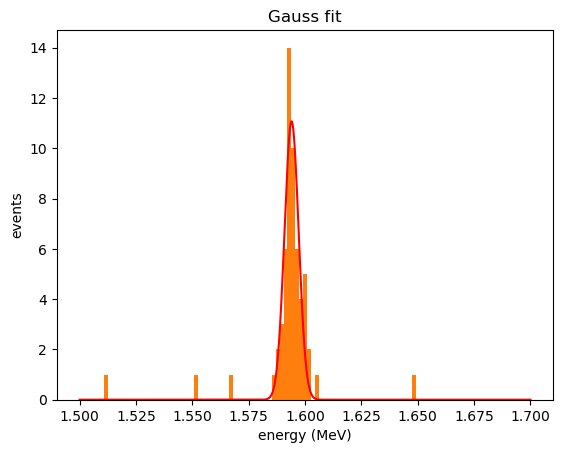

        Fitting output      
A: 11.0744 ± 0.4829
mu: 1.5940 ± 0.0002
sigma: 0.0031 ± 0.0002
=========================== FULL FIT ============================


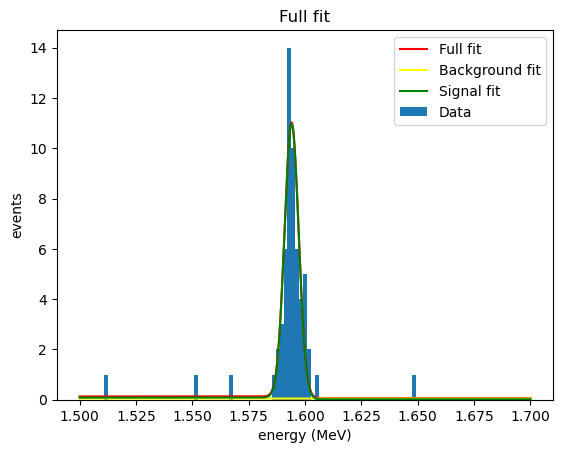

        Fitting output      
ns: 0.0859 ± 0.0032
a: 0.0060 ± 0.0639
nb: 0.0473 ± 0.0830
tau: -251185.0296 ± 0.0000
ns - 55.26892549750797
nb - 5.462701481615958
total = 61
Event no = 58
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 25734.03 ± 1766307.73
Applying cut 0.42 MeV
=========================== GAUSSIAN FIT ============================


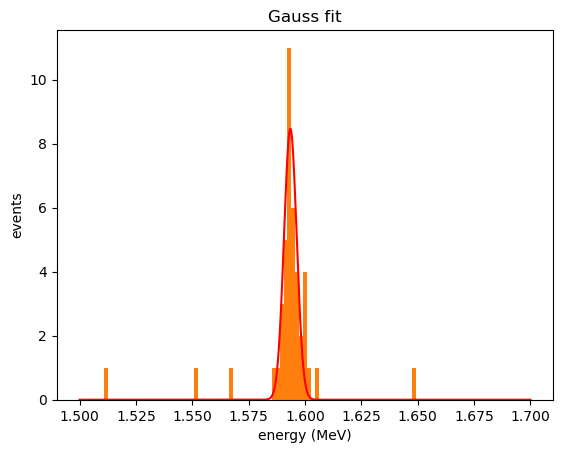

        Fitting output      
A: 8.4688 ± 0.4501
mu: 1.5935 ± 0.0002
sigma: 0.0028 ± 0.0002
=========================== FULL FIT ============================


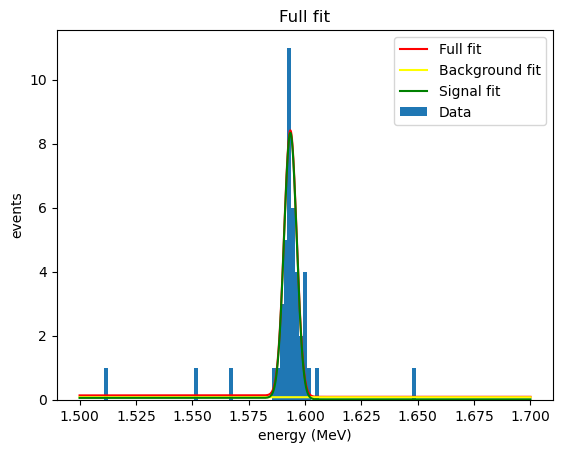

        Fitting output      
ns: 0.0582 ± 0.0027
a: 0.0053 ± 0.0779
nb: 0.0786 ± 0.0721
tau: -250595.8932 ± 0.0000
ns - 37.426674370615444
nb - 9.073351998785755
total = 47
Event no = 43
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 42743.30 ± 2933751.35
Applying cut 0.43 MeV
=========================== GAUSSIAN FIT ============================


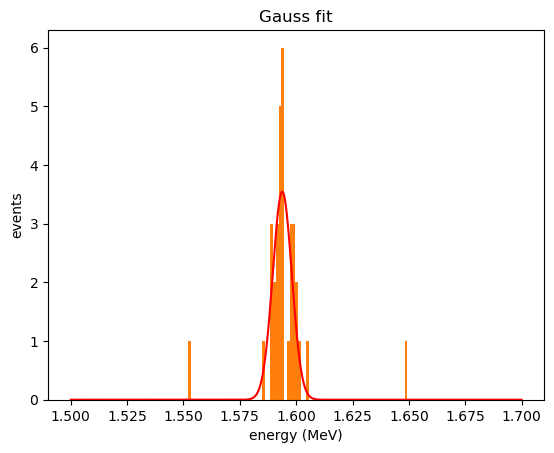

        Fitting output      
A: 3.5466 ± 0.3259
mu: 1.5938 ± 0.0004
sigma: 0.0042 ± 0.0004
=========================== FULL FIT ============================


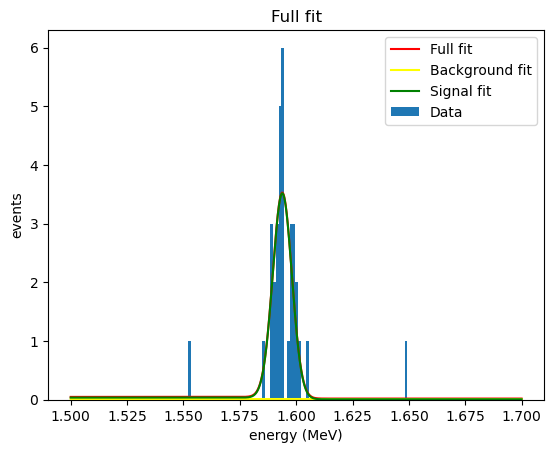

        Fitting output      
ns: 0.0370 ± 0.0031
a: 0.0081 ± 0.1358
nb: 0.0120 ± 0.0814
tau: -114879.8363 ± 0.0000
ns - 33.91645191762585
nb - 1.9668253252430785
total = 36
Event no = 33
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 9265.44 ± 635974.48
Applying cut 0.44 MeV
=========================== GAUSSIAN FIT ============================


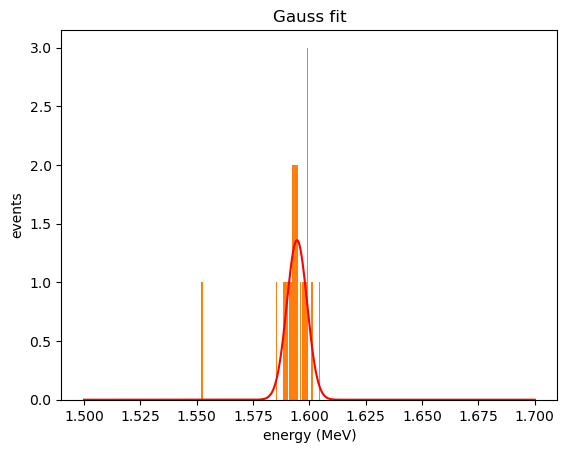

        Fitting output      
A: 1.3598 ± 0.1603
mu: 1.5945 ± 0.0006
sigma: 0.0045 ± 0.0006
=========================== FULL FIT ============================


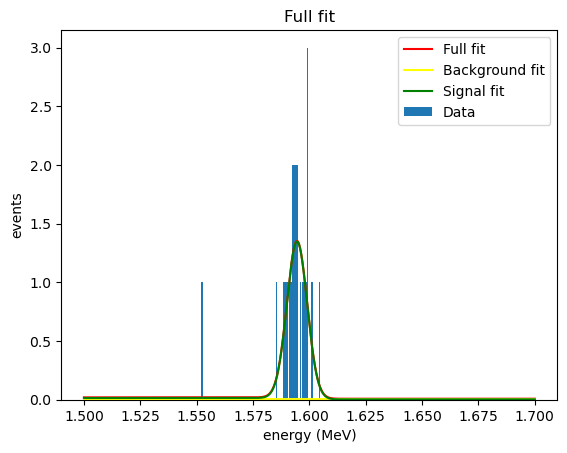

        Fitting output      
ns: 0.0150 ± 0.0018
a: 0.0092 ± 0.1741
nb: 0.0054 ± 0.0615
tau: 756461.8044 ± 0.0000
ns - 25.427972237424683
nb - 1.6431739965219698
total = 27
Event no = 24
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 7740.76 ± 531327.22
Applying cut 0.45 MeV
=========================== GAUSSIAN FIT ============================


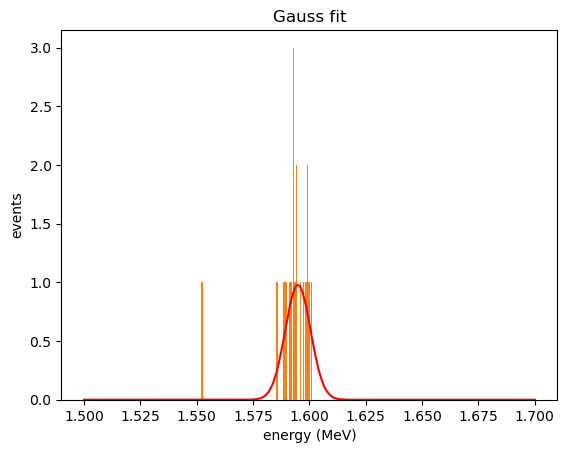

        Fitting output      
A: 0.9773 ± 0.1419
mu: 1.5949 ± 0.0011
sigma: 0.0056 ± 0.0013
=========================== FULL FIT ============================


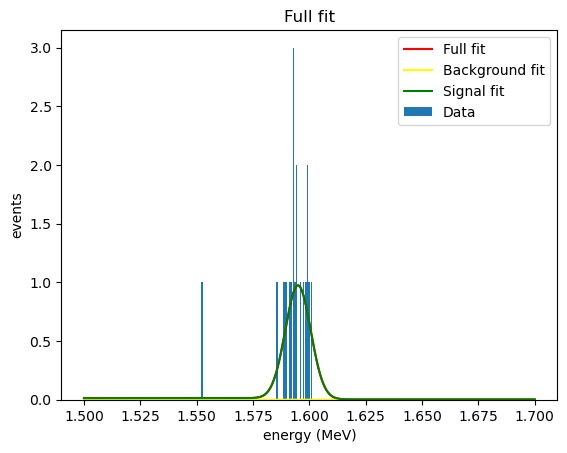

        Fitting output      
ns: 0.0136 ± 0.0020
a: 0.0146 ± 0.2390
nb: 0.0000 ± 0.0632
tau: -2285.3038 ± 0.0000
ns - 24.69375815842003
nb - 7.2020238328062435e-09
total = 25
Event no = 20
fom - 0.02 ± 139.55
e - 0.00 ± 0.00
b - 0.00 ± 0.40
Applying cut 0.46 MeV
=========================== GAUSSIAN FIT ============================


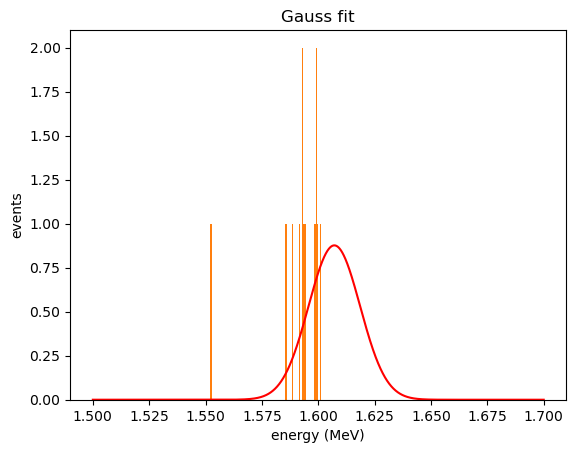

        Fitting output      
A: 0.8770 ± 0.9721
mu: 1.6071 ± 0.0239
sigma: 0.0114 ± 0.0103
=========================== FULL FIT ============================


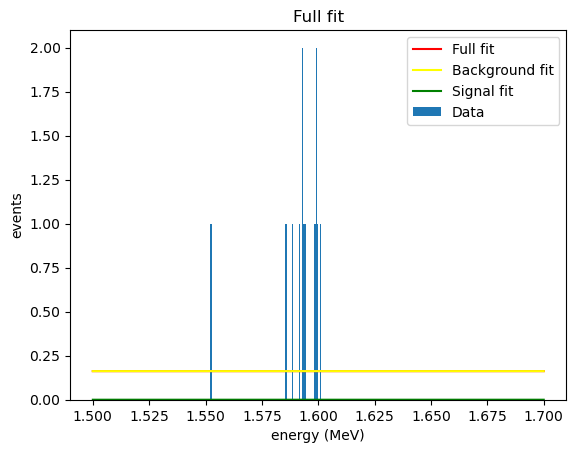

        Fitting output      
ns: 0.0000 ± 0.8568
a: 52.6475 ± 0.0000
nb: 0.1625 ± 0.8074
tau: 3396947.1134 ± 0.0000
ns - 1.3066180562540976e-14
nb - 52.840955847737995
total = 53
Event no = 13
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 248926.41 ± 17085276.02
Applying cut 0.47000000000000003 MeV
=========================== GAUSSIAN FIT ============================


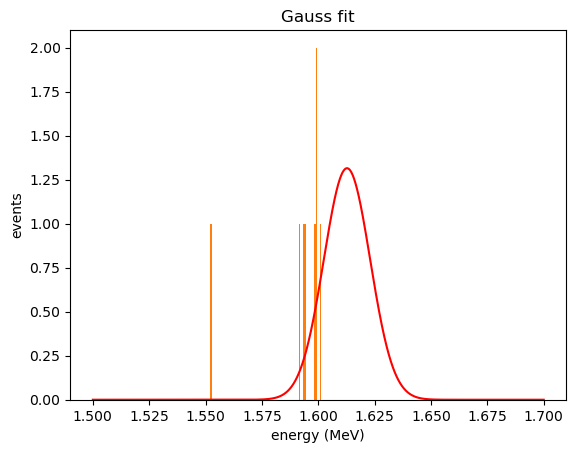

        Fitting output      
A: 1.3155 ± 5.3439
mu: 1.6127 ± 0.0527
sigma: 0.0103 ± 0.0162
=========================== FULL FIT ============================


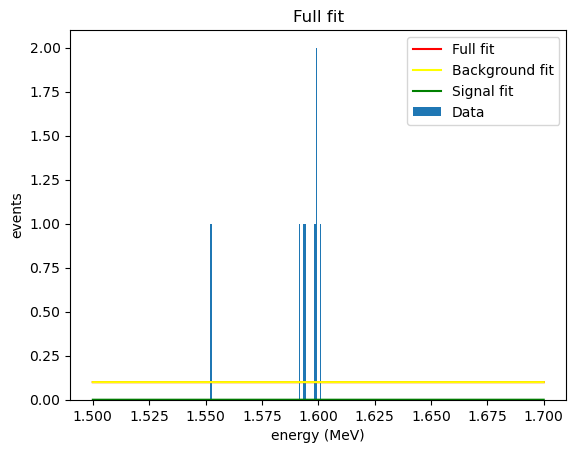

        Fitting output      
ns: 0.0000 ± 2.4976
a: 7.7458 ± 0.2078
nb: 0.1000 ± 7.8352
tau: 70204.2816 ± 186520649269.5700
ns - 3.505241535857009e-29
nb - 32.517437043455224
total = 33
Event no = 8
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 153185.13 ± 10514005.20
Applying cut 0.48 MeV
=========================== GAUSSIAN FIT ============================


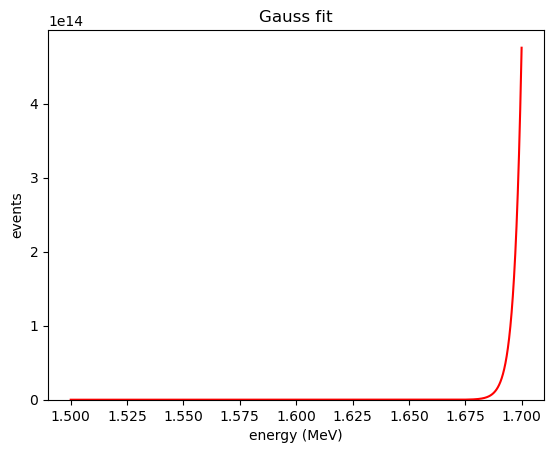

        Fitting output      
A: 7853388963166713187877074573857914880.0000 ± 268935104186076533235614623240512082018304.0000
mu: 2.0276 ± 169.9366
sigma: 0.0324 ± 6.4204
=========================== FULL FIT ============================


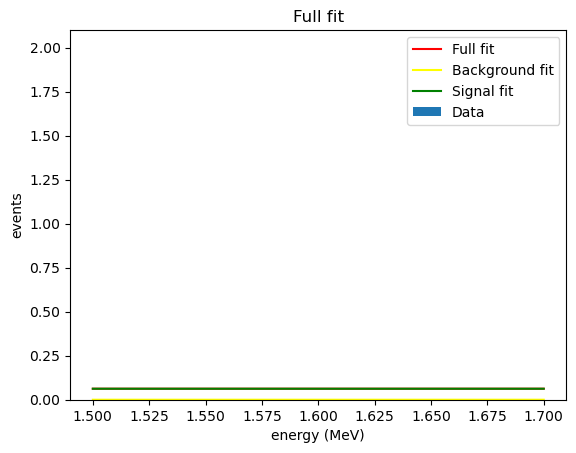

        Fitting output      
ns: 0.0641 ± 450.5366
a: 0.9707 ± 0.0002
nb: 0.0000 ± 459.5150
tau: 35.4552 ± 1454423179.0096
ns - 106.49658075860734
nb - 0.00029663623147823786
total = 106
Event no = 5
fom - 0.00 ± 0.02
e - 0.00 ± 0.00
b - 1.40 ± 125.63
Applying cut 0.49 MeV
=========================== GAUSSIAN FIT ============================


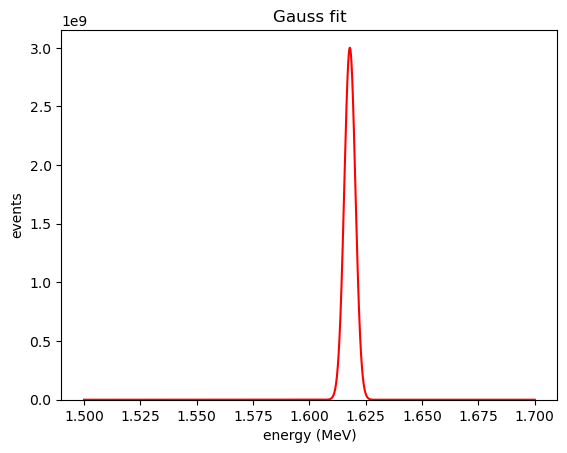

        Fitting output      
A: 3001077769.0242 ± 7598744912218.6436
mu: 1.6179 ± 1.8025
sigma: 0.0025 ± 0.1304
=========================== FULL FIT ============================


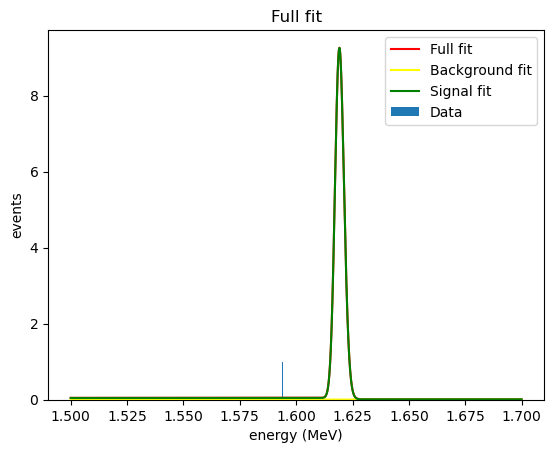

        Fitting output      
ns: 0.0466 ± 1088800.3005
a: 1.0001 ± 0.0000
nb: 0.0045 ± 1061707.7481
tau: -115536.2573 ± 0.0591
ns - 450.1134016455024
nb - 7.686144351720948
total = 458
Event no = 4
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 36208.36 ± 2485220.89
Applying cut 0.5 MeV
=========================== GAUSSIAN FIT ============================


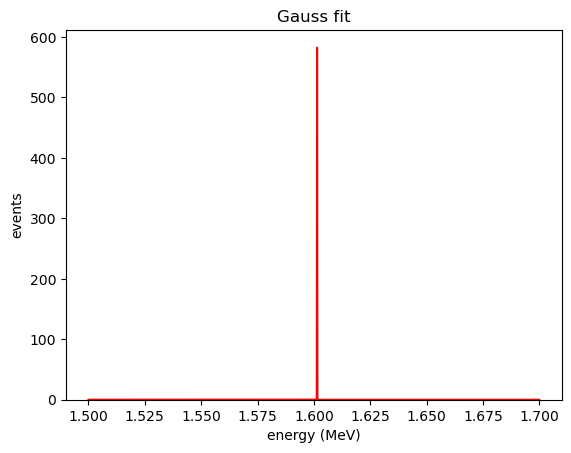

        Fitting output      
A: 582.4000 ± 10705846603.9964
mu: 1.6014 ± 404.4845
sigma: 0.0000 ± 44.5443
=========================== FULL FIT ============================


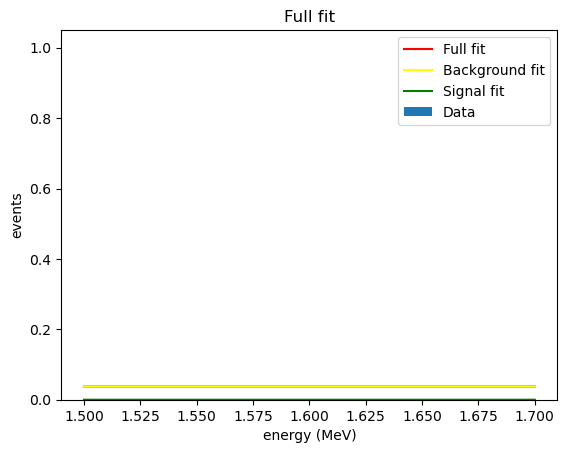

        Fitting output      
ns: 0.0000 ± 1432.0373
a: 7.9702 ± 0.0000
nb: 0.0375 ± 1396.4182
tau: -851393.9997 ± 0.0000
ns - 2.571804411734961e-06
nb - 81.9415377290984
total = 82
Event no = 3
fom - 0.00 ± 0.00
e - 0.00 ± 0.00
b - 386015.21 ± 26494463.78


In [22]:
cut_list = np.linspace(0,0.5, 51)
print(cut_list)

fom_out = fom_calc_MC(cut_tracks[0], pos_events, cut_list, verbose = True)

Text(0, 0.5, 'fom')

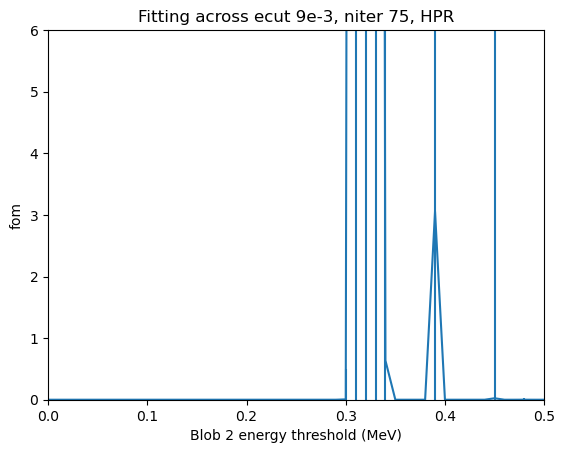

In [21]:
plt.errorbar(cut_list, fom_out[0], yerr = fom_out[1])
plt.title("Fitting across ecut 9e-3, niter 75, HPR")
plt.xlabel("Blob 2 energy threshold (MeV)")
plt.xlim([0,0.5])
plt.ylim([0,6])
plt.ylabel("fom")

In [ ]:
np.save('fittingfom.npy', fom_out)
np.save('blob2vals.npy', cut_list)